# Compare descriptors across FB groups
We believe that descriptors are used to provide additional context to locations that the audience is unfamiliar with. Does this play out in practice?

- $H_{0}$: P(loc, descriptor | A) = P(loc, descriptor | B) if loc in A
- $H_{1}$: P(loc, descriptor | A) < P(loc, descriptor | B) if loc in A

This will require the following:
- Extract all NEs from raw text.
- Identify all unambiguous location NEs.
- Identify descriptor phrases for NEs.
- Determine containment for all NEs (loc in X for all groups X).
- Compute P(loc, descriptor) across all groups.

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load data

In [35]:
from ast import literal_eval
# Facebook data
group_data = pd.read_csv('../../data/facebook-maria/combined_group_data_es_tagged.tsv', sep='\t', index_col=False)
# fix list columns
list_cols = ['status_message_tags', 'status_message_tags_ne']
for c in list_cols:
    group_data.loc[:, c] = group_data.loc[:, c].apply(literal_eval)
display(group_data.head())

,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_clean,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,Estoy preocupada por mi tia vicky vazquez que ...,"[(Estoy, O), (preocupada, O), (por, O), (mi, O...","[(asma, CAUSE_OF_DEATH), (Dorado, ORGANIZATION)]",estoy preocup por mi tia vicky vazquez que des...
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34,Para alguien que lo necesite... Dale Share..A ...,"[(Para, O), (alguien, O), (que, O), (lo, O), (...","[(Share, MISC), (general, TITLE), (Hipnoterapi...",par algui que lo necesit... da le share.<ne.mi...
2,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,En apoyo al alcalde Carlos Lopez y al municipi...,"[(En, O), (apoyo, O), (a, O), (el, O), (alcald...","[(alcalde, TITLE), (Carlos Lopez, PERSON), (Do...",en apoy a el alcalde.<ne.title> carlos_lopez.<...
3,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,Pueblo de Puerto Rico no se monten en las gran...,"[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...","[(Puerto Rico, COUNTRY), (America, MISC), (Pue...",puebl de puerto_rico.<ne.country> no se mont e...
4,351272391991842,141039043205101,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,es,351272391991842_358942134558201,2017-10-11 14:37:12,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,"[(PUEBLO, O), (DE, O), (PUERTO, O), (RICO, O),...","[(Estados Unidos, COUNTRY), (Puerto Rico, COUN...",puebl de puert ric no esper ningun ayud federa...


In [61]:
?pd.DataFrame.drop_duplicates

In [62]:
from unidecode import unidecode
import re
# geography data
geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False)

# geonames_data = geonames_data.iloc[:1000, :]
# remove parentheses names
parentheses_matcher = re.compile('\(.*$')
geonames_data.loc[:, 'name'] = geonames_data.loc[:, 'name'].apply(lambda x: parentheses_matcher.sub('', x))
geonames_data_PR = geonames_data[geonames_data.loc[:, 'country']=='PR']
# only keep duplicates with more alternate names
geonames_data_PR.sort_values(['name', 'alternate_name_count'], inplace=True, ascending=False)
geonames_data_PR.drop_duplicates(['name', 'latitude', 'longitude'], keep='first', inplace=True)
# fix alternate names
geonames_data_PR.loc[:, 'alternate_names'] = geonames_data_PR.loc[:, 'alternate_names'].fillna('')
geonames_data_PR.loc[:, 'alternate_names'] = geonames_data_PR.apply(lambda x: ','.join(set([x.loc['name']] + x.loc['alternate_names'].split(',')) - set([''])), axis=1)
geonames_data_PR.loc[:, 'name_fixed'] = geonames_data_PR.loc[:, 'name'].apply(lambda x: unidecode(x.lower()))
geonames_data_PR.loc[:, 'alternate_names_fixed'] = geonames_data_PR.loc[:, 'alternate_names'].apply(lambda x: ','.join(set(map(lambda y: unidecode(y.lower()), x.split(',')))))
# for x in geonames_data_PR.loc[:, 'alternate_names'].values:
#     try:
#         re.compile('|'.join(x.split(',')))
#     except Exception as e:
#         print('error at %s'%(x))
#         break
geonames_data_PR.loc[:, 'alternate_names_regex'] = geonames_data_PR.loc[:, 'alternate_names'].apply(lambda x: re.compile('|'.join(map(lambda y: '^%s$'%(y), x.split(',')))))
geonames_data_PR.loc[:, 'alternate_names_fixed_regex'] = geonames_data_PR.loc[:, 'alternate_names_fixed'].apply(lambda x: re.compile('|'.join(map(lambda y: '^%s$'%(y), x.split(',')))))
display(geonames_data_PR.head())
print('%d valid PR locations'%(geonames_data_PR.shape[0]))

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count,name_fixed,alternate_names_fixed,alternate_names_regex,alternate_names_fixed_regex
7739258,4562634,Área de Recreo El Yunque,"Area de Recreo El Yunque,Área de Recreo El Yunque",18.30245,-65.78572,L,PRK,PR,0,1,area de recreo el yunque,area de recreo el yunque,re.compile('^Area de Recreo El Yunque$|^Área d...,re.compile('^area de recreo el yunque$')
7739238,4562613,Ángeles,"Ángeles,Angeles",18.28495,-66.79934,P,PPL,PR,0,1,angeles,angeles,re.compile('^Ángeles$|^Angeles$'),re.compile('^angeles$')
7745471,4568936,Zona Portuaria,Zona Portuaria,18.42800,-66.10322,S,NaN,PR,0,1,zona portuaria,zona portuaria,re.compile('^Zona Portuaria$'),re.compile('^zona portuaria$')
7745470,4568935,Zona Industrial Boulevardo Maria,Zona Industrial Boulevardo Maria,18.29273,-67.13574,S,NaN,PR,0,1,zona industrial boulevardo maria,zona industrial boulevardo maria,re.compile('^Zona Industrial Boulevardo Maria$'),re.compile('^zona industrial boulevardo maria$')
7746716,7269321,Zenial Building,Zenial Building,18.43851,-66.05936,S,BLDG,PR,0,1,zenial building,zenial building,re.compile('^Zenial Building$'),re.compile('^zenial building$')


8241 valid PR locations


## Match extracted NEs

Match all extracted locations to an unambiguous location.

In [63]:
geonames_PR_name_counts = geonames_data_PR.loc[:, 'name_fixed'].value_counts()
geonames_PR_unambiguous_names = list(geonames_PR_name_counts[geonames_PR_name_counts == 1].index)
print('%d/%d unambiguous names'%(len(geonames_PR_unambiguous_names), len(geonames_PR_name_counts)))
geonames_data_PR_unambiguous = geonames_data_PR[geonames_data_PR.loc[:, 'name_fixed'].isin(geonames_PR_unambiguous_names)]
display(geonames_data_PR_unambiguous.head())

6717/7300 unambiguous names


,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count,name_fixed,alternate_names_fixed,alternate_names_regex,alternate_names_fixed_regex
7739258,4562634,Área de Recreo El Yunque,"Area de Recreo El Yunque,Área de Recreo El Yunque",18.30245,-65.78572,L,PRK,PR,0,1,area de recreo el yunque,area de recreo el yunque,re.compile('^Area de Recreo El Yunque$|^Área d...,re.compile('^area de recreo el yunque$')
7739238,4562613,Ángeles,"Ángeles,Angeles",18.28495,-66.79934,P,PPL,PR,0,1,angeles,angeles,re.compile('^Ángeles$|^Angeles$'),re.compile('^angeles$')
7745471,4568936,Zona Portuaria,Zona Portuaria,18.42800,-66.10322,S,NaN,PR,0,1,zona portuaria,zona portuaria,re.compile('^Zona Portuaria$'),re.compile('^zona portuaria$')
7745470,4568935,Zona Industrial Boulevardo Maria,Zona Industrial Boulevardo Maria,18.29273,-67.13574,S,NaN,PR,0,1,zona industrial boulevardo maria,zona industrial boulevardo maria,re.compile('^Zona Industrial Boulevardo Maria$'),re.compile('^zona industrial boulevardo maria$')
7746716,7269321,Zenial Building,Zenial Building,18.43851,-66.05936,S,BLDG,PR,0,1,zenial building,zenial building,re.compile('^Zenial Building$'),re.compile('^zenial building$')


In [64]:
test_data = group_data.iloc[[0]]
test_data = test_data.loc[:, 'status_message_tags_ne']
# print(test_data)
# test_data = [[('Share', 'TEST')]]
for x in test_data:
    for y in x:
        print(y[0])
        y_match = match_name(y[0].lower(), geonames_data_PR_unambiguous)
        print(y_match)
#         print(y_match.loc[:, 'alternate_names'].iloc[0])
# test_tags = test_data.loc[:, 'status_message_tags_ne'].apply(lambda x: list(filter(lambda y: match_name(y[0].lower(), geonames_data_PR_unambiguous).shape[0] > 0, x)))
# print(test_tags)

asma
Empty DataFrame
Columns: [geonames_ID, name, alternate_names, latitude, longitude, feature_class, feature_code, country, population, alternate_name_count, name_fixed, alternate_names_fixed, alternate_names_regex, alternate_names_fixed_regex]
Index: []
Dorado
         geonames_ID              name  \
7740727      4564134  Dorado Municipio   
7740726      4564133            Dorado   

                                           alternate_names  latitude  \
7740727                            Dorado,Dorado Municipio  18.43967   
7740726  Dorado,duo la duo,多拉多,dorado,ডোরাডো,دورادو، پو...  18.45883   

         longitude feature_class feature_code country  population  \
7740727  -66.28295             A         ADM1      PR       38165   
7740726  -66.26767             P         PPLA      PR       13117   

         alternate_name_count        name_fixed  \
7740727                     1  dorado municipio   
7740726                     8            dorado   

                              

In [65]:
def match_name(name, loc_data):
    loc_data_x = loc_data[loc_data.loc[:, 'alternate_names_fixed_regex'].apply(lambda x: x.search(name) is not None)]
    return loc_data_x
# print(group_data.head(10).loc[:, 'status_message_tags_ne'].apply(lambda x: list(filter(lambda y: match_name(y[0].lower(), geonames_data_PR_unambiguous).shape[0] > 0, x))))
group_data.loc[:, 'status_message_tags_ne_unambiguous'] = group_data.loc[:, 'status_message_tags_ne'].apply(lambda x: list(filter(lambda y: match_name(y[0].lower(), geonames_data_PR_unambiguous).shape[0] > 0, x)))

In [109]:
from collections import Counter
display(group_data.head())
# count all unambiguous locations
loc_counter = Counter()
for x in group_data.loc[:, 'status_message_tags_ne_unambiguous']:
    loc_counter.update([y[0] for y in x])
loc_counter = pd.Series(loc_counter).sort_values(inplace=False, ascending=False)
display(loc_counter.head(20))
print('%d unambiguous locations total'%(loc_counter.sum()))

,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_clean,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed,status_message_tags_ne_unambiguous
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,Estoy preocupada por mi tia vicky vazquez que ...,"[(Estoy, O), (preocupada, O), (por, O), (mi, O...","[(asma, CAUSE_OF_DEATH), (Dorado, ORGANIZATION)]",estoy preocup por mi tia vicky vazquez que des...,"[(Dorado, ORGANIZATION)]"
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34,Para alguien que lo necesite... Dale Share..A ...,"[(Para, O), (alguien, O), (que, O), (lo, O), (...","[(Share, MISC), (general, TITLE), (Hipnoterapi...",par algui que lo necesit... da le share.<ne.mi...,"[(Caguas, LOCATION), (Turabo Gardens, ORGANIZA..."
2,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,En apoyo al alcalde Carlos Lopez y al municipi...,"[(En, O), (apoyo, O), (a, O), (el, O), (alcald...","[(alcalde, TITLE), (Carlos Lopez, PERSON), (Do...",en apoy a el alcalde.<ne.title> carlos_lopez.<...,[]
3,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,Pueblo de Puerto Rico no se monten en las gran...,"[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...","[(Puerto Rico, COUNTRY), (America, MISC), (Pue...",puebl de puerto_rico.<ne.country> no se mont e...,[]
4,351272391991842,141039043205101,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,es,351272391991842_358942134558201,2017-10-11 14:37:12,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,"[(PUEBLO, O), (DE, O), (PUERTO, O), (RICO, O),...","[(Estados Unidos, COUNTRY), (Puerto Rico, COUN...",puebl de puert ric no esper ningun ayud federa...,[]


Guayama         897
Coamo           504
Ponce           492
Quebradillas    366
Yabucoa         327
Cidra           314
Patillas        282
Corozal         282
Cayey           258
Vega Alta       198
Utuado          196
Jardines        194
Lajas           192
Florida         178
Arecibo         142
Parque          124
Aguadilla       122
Caguas          118
Isabela         116
Naranjito       106
dtype: int64

10980 unambiguous locations total


Great! These all make sense as these are the main municipalities of interest.

Match group ID to location.

In [107]:
group_loc_data = pd.read_csv('../../data/facebook-maria/location_group_data.tsv', sep='\t', index_col=False)
display(group_loc_data.head())
# only 
# match location name to GeoNames ID
geonames_data_PR.sort_values(['name', 'alternate_name_count'], inplace=True, ascending=False)
def match_filter(x, loc_data, feature_code='ADM1'):
#     print(x)
    x_match = match_name(unidecode(x.lower()), loc_data)
#     print(x_match)
#     if(np.any(x_match.loc[:, 'feature_code']==feature_code)):
#         x_match = x_match[x_match.loc[:, 'feature_code']==feature_code]
    return x_match
group_loc_data.loc[:, 'geonames_ID'] = group_loc_data.loc[:, 'location_name'].apply(lambda x: match_filter(unidecode(x.lower()), geonames_data_PR, feature_code='ADM1').iloc[0].loc['geonames_ID'])
group_loc_data = pd.merge(group_loc_data, geonames_data_PR.loc[:, ['geonames_ID', 'latitude', 'longitude']], on='geonames_ID')
## compute centroid, loc count of each group
group_loc_data_centroids = group_loc_data.groupby('group_id').apply(lambda x: x.loc[:, ['latitude', 'longitude']].mean(axis=0))
group_loc_data_centroids = group_loc_data_centroids.reset_index(inplace=False).rename(columns={'latitude':'latitude_centroid', 'longitude':'longitude_centroid'}, inplace=False)
group_loc_data_counts = group_loc_data.loc[:, 'group_id'].value_counts().reset_index(inplace=False).rename(columns={'index':'group_id', 'group_id':'loc_count'}, inplace=False)
## combine
group_loc_data = pd.merge(group_loc_data, group_loc_data_centroids, on='group_id')
group_loc_data = pd.merge(group_loc_data, group_loc_data_counts, on='group_id')
group_loc_data_unique = group_loc_data.drop_duplicates('group_id', keep='first')
display(group_loc_data_unique.head())
# group_data_combined = pd.merge(group_data, group_loc_data.loc[:, ['location_name', 'group_id']], on='group_id')
# display(group_data_combined.head())

,location_name,group_id,group_name
0,Aguada,1724474021195839,Huracan Maria Anasco y Aguada
1,Aguadilla,117529462276443,Huracan Maria Aguadilla
2,Aguadilla,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero
3,Aguas Buenas,1723084327997466,Aguas Buenas Huracan Maria
4,Aguas Buenas,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, ar..."


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,location_name,group_id,group_name,geonames_ID,latitude,longitude,latitude_centroid,longitude_centroid,loc_count
0,Aguada,1724474021195839,Huracan Maria Anasco y Aguada,4562502,18.37939,-67.18824,18.331060,-67.16393,2
2,Aguadilla,117529462276443,Huracan Maria Aguadilla,4562506,18.42745,-67.15407,18.427450,-67.15407,1
3,Aguadilla,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero,4562506,18.42745,-67.15407,18.343980,-66.41295,2
5,Aguas Buenas,1723084327997466,Aguas Buenas Huracan Maria,4562516,18.25690,-66.10294,18.256900,-66.10294,1
6,Aguas Buenas,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, ar...",4562516,18.25690,-66.10294,18.227318,-66.09558,4


### Map locations by group

Sanity check: are the locations mentioned in each group somewhat close to their centroid locations? Let's do some plotting.

In [140]:
# match each unambiguous location to a GeoNames entry
group_data.loc[:, 'status_message_tags_ne_unambiguous_geonames'] = group_data.loc[:, 'status_message_tags_ne_unambiguous'].apply(lambda x: list(map(lambda y: match_name(unidecode(y[0].lower()), geonames_data_PR_unambiguous).iloc[0], x)))
# collect all unambiguous locations per group
group_data_locs_ordered = []
for group_id_i, group_data_i in group_data.groupby('group_id'):
    group_data_i = group_data_i[group_data_i.loc[:, 'status_message_tags_ne_unambiguous'].apply(lambda x: len(x) > 0)]
    if(group_data_i.shape[0] > 0):
        try:
            loc_data_i = pd.concat([pd.DataFrame(y) for y in group_data_i.loc[:, 'status_message_tags_ne_unambiguous_geonames']], axis=0)
            loc_data_i.loc[:, 'group_id'] = group_id_i
            loc_data_i.loc[:, 'status_id'] = group_data_i.loc[:, 'status_id'].values[0]
            group_data_locs_ordered.append(loc_data_i)
        except Exception as e:
            print(e)
            print('error with group data %s'%(group_data_i))
            break
group_data_locs_ordered = pd.concat(group_data_locs_ordered, axis=0)
group_data_locs_ordered.index = np.arange(group_data_locs_ordered.shape[0])
print(group_data_locs_ordered.shape)
# group_data_locs_ordered = group_data.groupby('group_id').apply(lambda x: pd.concat([pd.DataFrame(y) for y in x.loc[:, 'status_message_tags_ne_unambiguous_geonames']], axis=0).transpose())
display(group_data_locs_ordered.head())

(10980, 16)


,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count,name_fixed,alternate_names_fixed,alternate_names_regex,alternate_names_fixed_regex,group_id,status_id
0,4566209,Maunabo Municipio,"Maunabo Municipio,Maunabo",18.01691,-65.92738,A,ADM1,PR,12225,1,maunabo municipio,"maunabo municipio,maunabo",re.compile('^Maunabo Municipio$|^Maunabo$'),re.compile('^maunabo municipio$|^maunabo$'),105121436871597,105121436871597_105122476871493
1,4566209,Maunabo Municipio,"Maunabo Municipio,Maunabo",18.01691,-65.92738,A,ADM1,PR,12225,1,maunabo municipio,"maunabo municipio,maunabo",re.compile('^Maunabo Municipio$|^Maunabo$'),re.compile('^maunabo municipio$|^maunabo$'),105121436871597,105121436871597_105122476871493
2,4563011,Caguas Municipio,"Caguas Municipio,Caguas",18.21329,-66.04961,A,ADM1,PR,142893,1,caguas municipio,"caguas municipio,caguas",re.compile('^Caguas Municipio$|^Caguas$'),re.compile('^caguas municipio$|^caguas$'),105121436871597,105121436871597_105122476871493
3,4566209,Maunabo Municipio,"Maunabo Municipio,Maunabo",18.01691,-65.92738,A,ADM1,PR,12225,1,maunabo municipio,"maunabo municipio,maunabo",re.compile('^Maunabo Municipio$|^Maunabo$'),re.compile('^maunabo municipio$|^maunabo$'),105121436871597,105121436871597_105122476871493
4,4568639,Villa Navarro,Villa Navarro,18.00469,-65.89572,P,PPL,PR,0,1,villa navarro,villa navarro,re.compile('^Villa Navarro$'),re.compile('^villa navarro$'),105121436871597,105121436871597_105122476871493


testing group Huracan Maria Maunabo with 7 locations
centroid [[18.01691 -65.92738]]


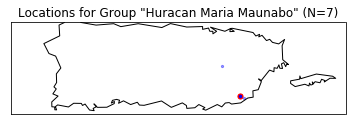

testing group Huracan Maria Humacao with 7 locations
centroid [[18.148020000000002 -65.81211]]


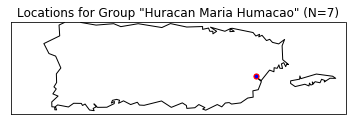

testing group Huracan Maria Utuado with 404 locations
centroid [[18.27301 -66.69962]]


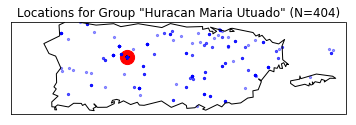

testing group Huracan Maria Aguadilla with 2 locations
centroid [[18.42745 -67.15406999999999]]


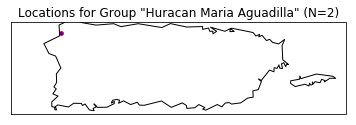

testing group Arroyo: Huracán Maria with 131 locations
centroid [[17.9658 -66.06128000000001]]


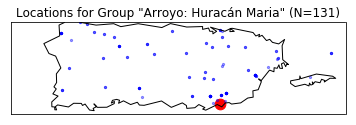

testing group Quebradillas#Huracan#Maria with 557 locations
centroid [[18.43967 -66.92461999999999]]


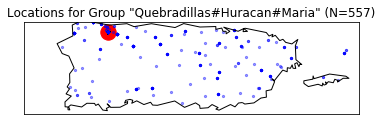

testing group Updates de Familia en Isabela y Huracan Maria with 112 locations
centroid [[18.50078 -67.02435]]


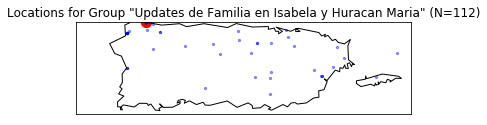

testing group Huracán María Naguabo with 19 locations
centroid [[18.23135 -65.75988000000001]]


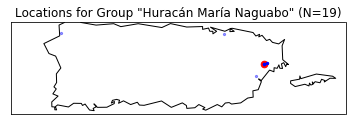

testing group Barranquitas Huracan Maria with 467 locations
centroid [[18.18662 -66.30628]]


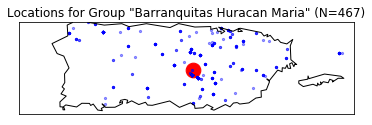

testing group Huracán María Dorado with 17 locations
centroid [[18.43967 -66.28295]]


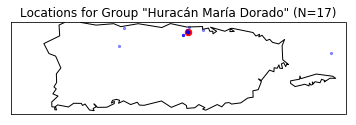

testing group Huracan Maria Juana Diaz, Villaba Puerto Rico with 59 locations
centroid [[18.04802 -66.49266999999999]]


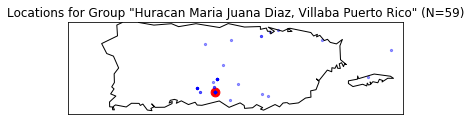

testing group Huracán Maria Cataño & Amelía with 5 locations
centroid [[18.4355 -66.13710999999999]]


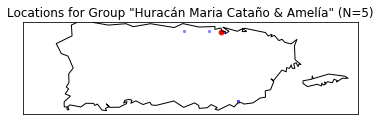

testing group Huracan Maria  Yabucoa with 596 locations
centroid [[18.07302 -65.88710999999999]]


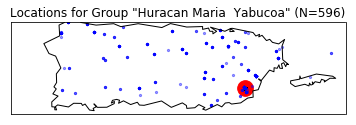

testing group Huracan Maria En Lajas with 301 locations
centroid [[18.0133 -67.0399]]


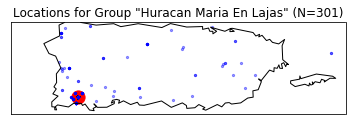

testing group Huracán Maria Vega Alta (Unidos por Vega Alta) with 668 locations
centroid [[18.4105 -66.33295]]


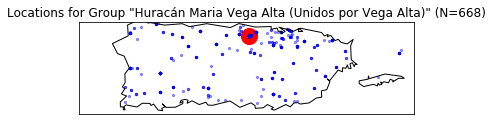

testing group Cayey se levanta ante el paso del huracán María. with 467 locations
centroid [[18.10357 -66.15378]]


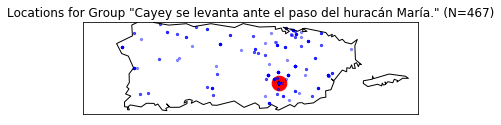

testing group Huracán María: Información de Ponce y Areas Adyacentes with 216 locations
centroid [[18.07302 -66.61851]]


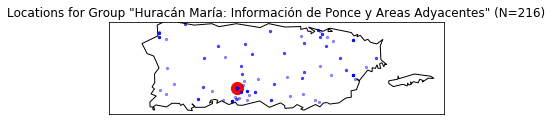

testing group MAYAGUEZ OESTE HURACAN MARIA with 104 locations
centroid [[18.20496 -67.1024]]


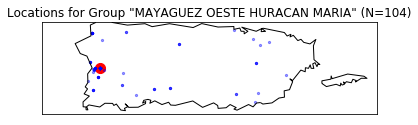

testing group Huracán María Comerío Bayamón Aguas Buenas, area central yabucoa pide ayuda with 19 locations
centroid [[18.2273175 -66.09558]]


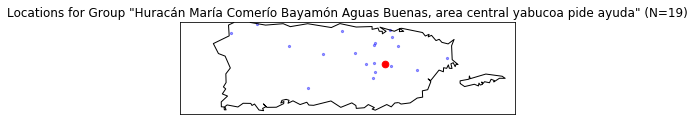

testing group PATILLAS después del Huracán María with 359 locations
centroid [[18.041629999999998 -66.01765999999999]]


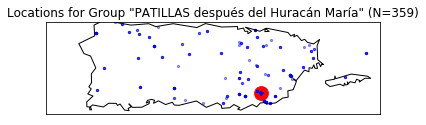

testing group Huracan Maria en Coamo with 229 locations
centroid [[18.09802 -66.36211]]


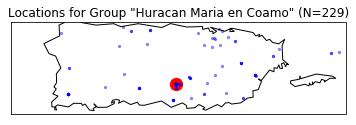

testing group Dorado Puerto Rico Huracan Maria with 24 locations
centroid [[18.43967 -66.28295]]


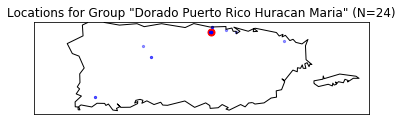

testing group huracán María Caguas with 2 locations
centroid [[18.21329 -66.04961]]


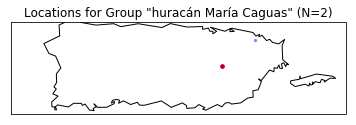

testing group Huracan Maria Vega Baja with 180 locations
centroid [[18.42578 -66.39961]]


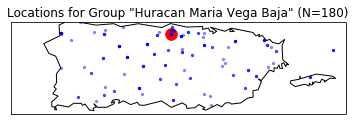

testing group Huracán Maria Yabucoa with 160 locations
centroid [[18.07302 -65.88710999999999]]


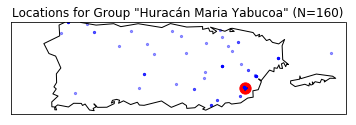

testing group Huracan Maria Dorado Puerto Rico with 31 locations
centroid [[18.43967 -66.28295]]


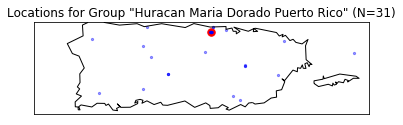

testing group Huracan María en San lorenzo with 17 locations
centroid [[18.15496 -65.97461]]


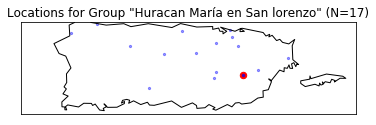

testing group Huracan Maria Quebrada Areanas Vega Baja with 2 locations
centroid [[18.42578 -66.39961]]


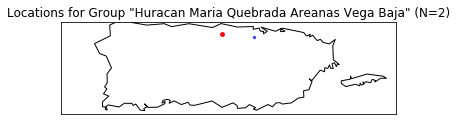

testing group Huracan Maria Naranjito with 158 locations
centroid [[18.28968 -66.25516999999999]]


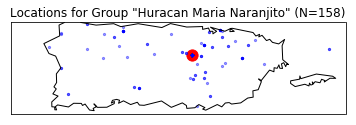

testing group Huracan Maria Area San German y Pueblos Limitrofes with 39 locations
centroid [[18.11468 -67.03573]]


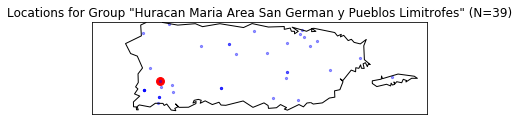

testing group Ponce Unidos!  #Huracan Maria with 474 locations
centroid [[18.07302 -66.61851]]


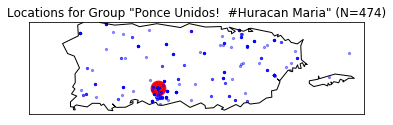

testing group !Estamos aqui!,San lorenzo,Puerto Rico ,Huracan Maria with 11 locations
centroid [[18.15496 -65.97461]]


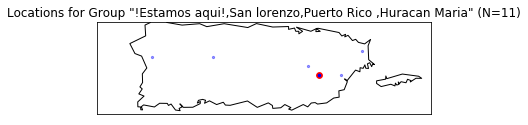

testing group Huracán Maria- Bayamon with 61 locations
centroid [[18.35217 -66.17044]]


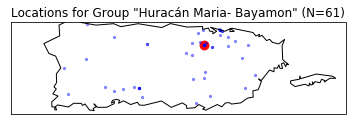

testing group Se Buscan Mayaguez PR Huracan Maria with 30 locations
centroid [[18.20496 -67.1024]]


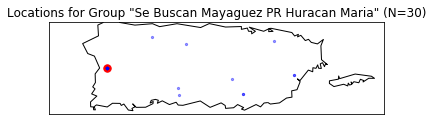

testing group Huracan Maria San German with 105 locations
centroid [[18.11468 -67.03573]]


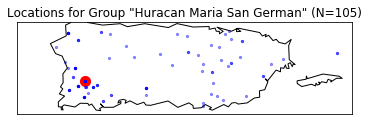

testing group Coamo después del Huracán María with 3 locations
centroid [[18.09802 -66.36211]]


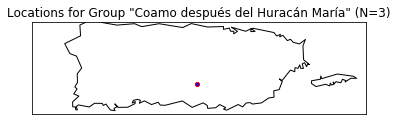

testing group Huracán María Trujillo Alto (grupo) with 52 locations
centroid [[18.341620000000002 -66.00516999999999]]


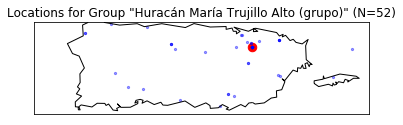

testing group Huracan Maria Coamo with 749 locations
centroid [[18.09802 -66.36211]]


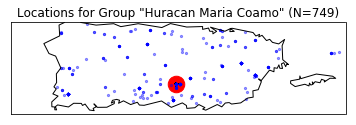

testing group Valenciano Abajo Y Valenciano Arriba JUNCOS - After Huracán María with 12 locations
centroid [[18.22607 -65.9185]]


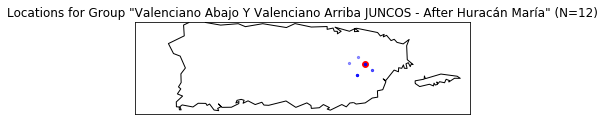

testing group Manati huracan Maria with 20 locations
centroid [[18.41884 -66.49266999999999]]


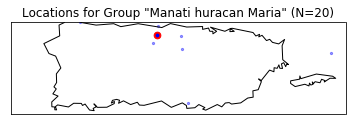

testing group Corozal Puerto Rico Huracan Maria  Plataneros with 2 locations
centroid [[18.30912 -66.32600000000001]]


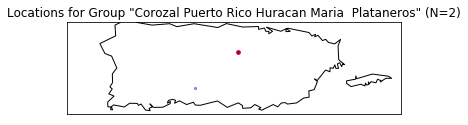

testing group Fotos Ponce Huracan Maria with 6 locations
centroid [[18.07302 -66.61851]]


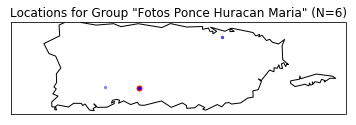

testing group Huracan Maria, Patillas with 204 locations
centroid [[18.041629999999998 -66.01765999999999]]


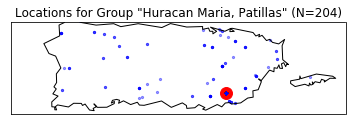

testing group Huracan Maria - Aguadilla - Ceiba Baja y Guerrero with 6 locations
centroid [[18.343980000000002 -66.41295]]


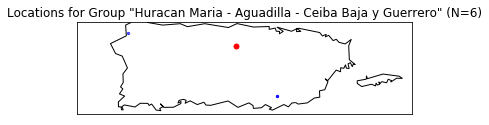

testing group Toa Alta Huracan Maria with 9 locations
centroid [[18.36606 -66.25378]]


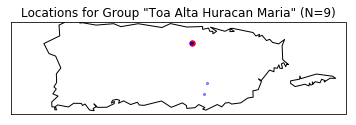

testing group Huracan Maria en Caguas with 2 locations
centroid [[18.21329 -66.04961]]


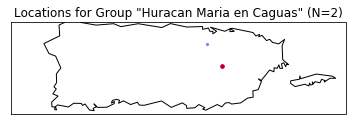

testing group Orocovis Huracan  Maria with 36 locations
centroid [[18.21885 -66.43712]]


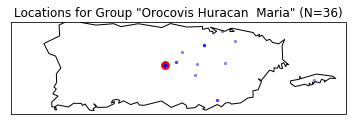

testing group Aguas Buenas Huracan Maria with 207 locations
centroid [[18.2569 -66.10294]]


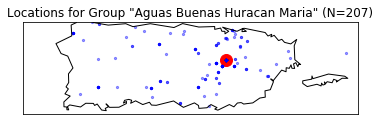

testing group Huracan Maria Anasco y Aguada with 43 locations
centroid [[18.33106 -67.16393]]


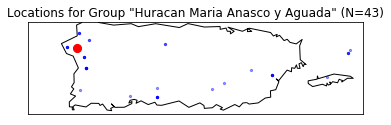

testing group Huracan Maria Areas De Canovanas with 13 locations
centroid [[18.338279999999997 -65.88710999999999]]


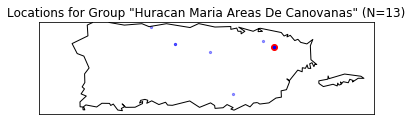

testing group Guayama: Huracán María with 2123 locations
centroid [[18.01663 -66.13072]]


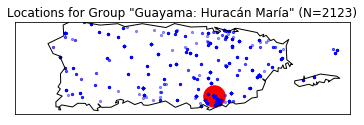

testing group HURACAN MARIA CIDRA with 489 locations
centroid [[18.17579 -66.16211]]


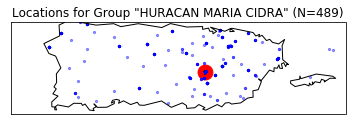

testing group Cidra, Puerto Rico ante el paso del Huracán María with 149 locations
centroid [[18.17579 -66.16211]]


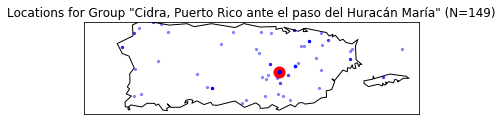

testing group Barrio Maricao Huracan Maria with 2 locations
centroid [[18.17301 -66.94546]]


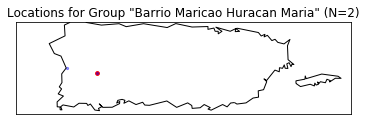

testing group Noticias de Lares Despues Huracan Maria with 35 locations
centroid [[18.270229999999998 -66.86907]]


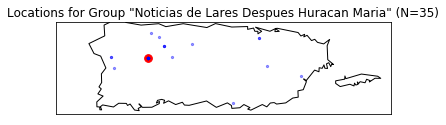

testing group Noticias!! Huracan Maria Vega Baja with 227 locations
centroid [[18.42578 -66.39961]]


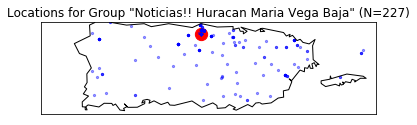

testing group Corozal huracan Maria with 436 locations
centroid [[18.30912 -66.32600000000001]]


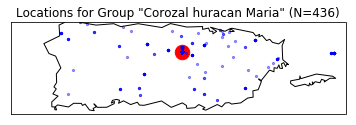

testing group Huracan Maria Quebradillas with 115 locations
centroid [[18.43967 -66.92461999999999]]


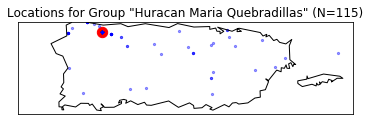

In [307]:
from mpl_toolkits.basemap import Basemap
x_bounds = [-67.5, -65.2]
y_bounds = [17.9, 18.5]
basemap = Basemap(llcrnrlon=x_bounds[0], llcrnrlat=y_bounds[0], urcrnrlon=x_bounds[1], urcrnrlat=y_bounds[1], projection='merc', resolution='i')
for group_id_i, group_data_i in group_data_locs_ordered.groupby('group_id'):
    name_i = group_loc_data_unique[group_loc_data_unique.loc[:, 'group_id']==group_id_i].iloc[0].loc['group_name']
    print('testing group %s with %d locations'%(name_i, group_data_i.shape[0]))
    # get group centroid
    centroid_i = group_loc_data_unique[group_loc_data_unique.loc[:, 'group_id']==group_id_i].iloc[0].loc[['latitude_centroid', 'longitude_centroid']].values.reshape(1, -1)
    print('centroid %s'%(centroid_i))
    centroid_x, centroid_y = basemap(centroid_i[:, 1], centroid_i[:, 0])
#     plt.figure(figsize=(5,5))
    basemap.drawcoastlines()
    ## plot centroid
    centroid_size = (group_data_i.shape[0]**.5)*10
    basemap.scatter(centroid_x, centroid_y, c='r', s=centroid_size)
    ## plot location mentions
    group_data_x, group_data_y = basemap(group_data_i.loc[:, 'longitude'].values, group_data_i.loc[:, 'latitude'].values)
    basemap.scatter(group_data_x, group_data_y, c='b', s=5., alpha=0.4)
    plt.title('Locations for Group "%s" (N=%d)'%(name_i, group_data_i.shape[0]))
    plt.show()

In general, it looks like each group tends to talk about locations that are geographically close to the centroid. Is this statistically true?

- $H_{0}$: distance between centroid and a location mentioned is equal to the distance between centroid and random location
- $H_{1}$: distance between centroid and a location mentioned is less than the distance between centroid and random location

In [214]:
from geopy.distance import great_circle
from shapely.geometry import Point
from scipy.stats import mannwhitneyu, median_test
np.random.seed(123)
min_loc_count = 30
p_thresh = 0.05 / len([y for x, y in group_data_locs_ordered.groupby('group_id') if y.shape[0] > min_loc_count])
for group_id_i, group_data_i in group_data_locs_ordered.groupby('group_id'):
    N_i = group_data_i.shape[0]
    if(N_i > min_loc_count):
        print('testing group %s N=%d'%(group_id_i, N_i))
        centroid_i = group_loc_data_unique[group_loc_data_unique.loc[:, 'group_id']==group_id_i].iloc[0].loc[['latitude_centroid', 'longitude_centroid']].values
        dists_i = group_data_i.loc[:, ['latitude', 'longitude']].apply(lambda x: great_circle(x.values, centroid_i).miles, axis=1).values
        group_data_rand_i = group_data_locs_ordered.loc[np.random.choice(group_data_locs_ordered.index, N_i, replace=True), :]
        dists_i_rand = group_data_rand_i.loc[:, ['latitude', 'longitude']].apply(lambda x: great_circle(x.values, centroid_i).miles, axis=1).values
        dists_diff_i = dists_i - dists_i_rand
        dists_diff_i_median = np.median(dists_diff_i)
#         print('diff median %.3f'%(dists_diff_i_median))
#         test_stat, p_val = mannwhitneyu(dists_i, dists_i_rand)
        test_stat, p_val, _, _ = median_test(dists_i, dists_i_rand)
#         print('median difference=%.3f; test_stat=%.3f (p=%.3f)'%(dists_diff_i_median, test_stat, p_val))
        if(p_val < p_thresh):
            print('median difference=%.3f; test_stat=%.3f (p=%.3f)'%(dists_diff_i_median, test_stat, p_val))
#         print(dists_i)

testing group 117445378946554 N=404
median difference=-18.164; test_stat=68.931 (p=0.000)
testing group 118787682128186 N=131
testing group 119087272129297 N=557
median difference=-31.135; test_stat=256.770 (p=0.000)
testing group 119132632075224 N=112
median difference=-39.779; test_stat=70.875 (p=0.000)
testing group 127217134598253 N=467
median difference=-7.482; test_stat=23.452 (p=0.000)
testing group 130010134396359 N=59
median difference=-18.185; test_stat=43.932 (p=0.000)
testing group 130913387550000 N=596
median difference=-17.305; test_stat=102.787 (p=0.000)
testing group 132022090761950 N=301
median difference=-48.408; test_stat=324.528 (p=0.000)
testing group 132392547395104 N=668
median difference=-8.930; test_stat=60.402 (p=0.000)
testing group 132963337341347 N=467
median difference=-11.956; test_stat=93.809 (p=0.000)
testing group 142680509678003 N=216
median difference=-18.452; test_stat=65.335 (p=0.000)
testing group 185336475344755 N=104
median difference=-36.037; t

In almost all groups, the actual locations are closer than random locations. Sanity check complete!

### Compare info status by group

Main research question: does a group that does not contain location A tend to treat A as new information?

We'll use the parses provided by Google to approximate information status.

In [221]:
import networkx as nx
# define method for extracting dependency relations
def extract_dep(tree, dedup_subtrees=False, noun_types = ['NOUN', 'PROPN']):
    # identify PROPN, then identify any attached appositive/PP phrases
    tree = [x + [i] for i,x in enumerate(tree)] # add index for bookkeeping
    np_heads = list(filter(lambda x: x[1] in noun_types, tree))
    np_descendants = []
    tree_graph = nx.DiGraph()
    for i, dep in enumerate(tree):
        tree_graph.add_edge(dep[2], i, pos=dep[1], name='/'.join(map(str, dep)), dep=dep)
    for np_head_i in np_heads:
        idx = np_head_i[4]
        # collect descendents
        desc_i = nx.descendants(tree_graph, idx)
        desc_i = [np_head_i] + [tree[j] for j in desc_i]
        # sort by sentence order
        desc_i = sorted(desc_i, key=lambda x: x[4])
        np_descendants.append(desc_i)
    # get rid of subordinate (duplicate) trees
    if(dedup_subtrees):
        np_descendants_dedup = []
        np_descendants_dedup_str = []
        np_descendants_str = list(map(lambda x: list(map(lambda y: '/'.join(map(str, y)), x)), np_descendants))
        for desc_i in sorted(np_descendants, key=lambda x: len(x), reverse=True):
            desc_str = list(map(lambda x: '/'.join(map(str, x)), desc_i))
            prev_match = False
            for np_descendants_dedup_str_i in np_descendants_dedup_str:
                if(len(set(np_descendants_dedup_str_i) - set(desc_str)) < len(np_descendants_dedup_str_i)):
                    prev_match = True
                    break
            if(not prev_match):
                np_descendants_dedup_str.append(desc_str)
                np_descendants_dedup.append(desc_i)
        np_descendants = np_descendants_dedup
    return np_descendants

In [229]:
group_data_parses.loc[:, 'status_message_parsed'].iloc[0]

[['En', 'ADP', '0', 'root'],
 ['apoyo', 'NOUN', '0', 'pobj'],
 ['al', 'ADP', '1', 'prep'],
 ['alcalde', 'NOUN', '2', 'pobj'],
 ['Carlos', 'PROPN', '3', 'appos'],
 ['Lopez', 'PROPN', '4', 'nn'],
 ['y', 'CONJ', '0', 'cc'],
 ['al', 'ADP', '12', 'prep'],
 ['municipio', 'NOUN', '7', 'pobj'],
 ['de', 'ADP', '8', 'prep'],
 ['Dorado', 'PROPN', '9', 'pobj'],
 ['Dorado', 'PROPN', '10', 'amod'],
 ['tiene', 'VERB', '0', 'conj'],
 ['voz', 'NOUN', '12', 'dobj']]

In [235]:
from ast import literal_eval
group_data_parses = pd.read_csv('../../data/facebook-maria/combined_group_data_es_tagged_parsed.txt', sep='\t', index_col=False)
group_data_parses.columns = ['status_id', 'status_message_parsed']
group_data_parses.loc[:, 'status_message_parsed'] = group_data_parses.loc[:, 'status_message_parsed'].apply(lambda x: [y.split('/') for y in x.split(' ')])
group_data_parses.loc[:, 'status_message_parsed'] = group_data_parses.loc[:, 'status_message_parsed'].apply(lambda x: [y for y in x if len(y) == 4])
# for x in group_data_parses.loc[:, 'status_message_parsed']:
#     print(x)
#     for y in x:
#         print(y)
#         y_1 = [y[0], y[1], int(y[2]), y[3]]
group_data_parses.loc[:, 'status_message_parsed'] = group_data_parses.loc[:, 'status_message_parsed'].apply(lambda x: [[y[0], y[1], int(y[2]), y[3]] for y in x])
# extract all head NNPs and their children
group_data_parses.loc[:, 'status_message_parsed_children'] = group_data_parses.loc[:, 'status_message_parsed'].apply(lambda x: extract_dep(x, noun_types='PROPN'))
display(group_data_parses.head())

,status_id,status_message_parsed,status_message_parsed_children
0,351272391991842_361453717640376,"[[En, ADP, 0, root], [apoyo, NOUN, 0, pobj], [...","[[[Carlos, PROPN, 3, appos, 4], [Lopez, PROPN,..."
1,351272391991842_358929311226150,"[[Pueblo, NOUN, 6, nsubj], [de, ADP, 0, prep],...","[[[Puerto, PROPN, 1, pobj, 2], [Rico, PROPN, 2..."
2,351272391991842_358929311226150,"[[No, ADV, 2, neg], [se, PRON, 2, prt], [metan...","[[[los, DET, 13, det, 12], [Estados, PROPN, 11..."
3,351272391991842_357797888005959,"[[Guayama, PROPN, 0, root], [,, PUNCT, 0, p], ...","[[[Guayama, PROPN, 0, root, 0], [,, PUNCT, 0, ..."
4,351272391991842_356944798091268,"[[Videos, NOUN, 0, root], [de, ADP, 0, prep], ...","[[[Dorado, PROPN, 0, p, 2]], [[Huracan, PROPN,..."


In [303]:
## let's do this the right way
## backoff = start with all contiguous PROPN near head
## if no match, try just head PROPN
def collect_NP(children):
    head_idx, head = min([[j, x] for j, x in enumerate(test_children_i)], key=lambda x: x[1][2])
    NP_complete_left = False
    NP_complete_right = False
    NP = []
    left_idx = head_idx
    right_idx = head_idx
    while(not (NP_complete_left or NP_complete_right)):
#         print('left=%d,right=%d'%(left_idx, right_idx))
        if(right_idx >= len(children)-1 or children[right_idx+1][1] != 'PROPN'):
            NP_complete_right = True
        else:
            right_idx += 1
        if(left_idx == 0 or children[left_idx-1][1] != 'PROPN'):
            NP_complete_left = True
        else:
            left_idx -= 1
    NP = children[left_idx:right_idx+1]
    return NP

def collect_match_NP(children_list, geo_data):
    """
    Collect all head NNPs from children
    and try to match each one on geo data.
    
    :param children_list: list of head NNPs/NPs with children
    :param geo_data: geo gazetteer
    :returns NP_match_list:: list of head NNPs/NPs with children, matched with geo-data (lat/lon)
    """
    NP_match_list = []
    for children_i in children_list:
        NP_i = collect_NP(children_i)
#         print('collected NP %s'%(NP_i))
        NP_str_i = ' '.join([x[0] for x in NP_i])
        NP_str_i_fixed = unidecode(NP_str_i.lower())
#         print('collected NP fixed %s'%(NP_str_i_fixed))
        # try to match!!
        geo_data_i = geo_data[geo_data.loc[:, 'alternate_names_fixed_regex'].apply(lambda x: x.search(NP_str_i_fixed) is not None)]
        if(geo_data_i.shape[0] > 0):
            geo_coord_i = list(geo_data_i.iloc[0].loc[['latitude', 'longitude']].values)
            NP_match_i = [NP_str_i, geo_coord_i, children_i]
            NP_match_list.append(NP_match_i)
    return NP_match_list

## test: collect NP
test_children_list = group_data_parses.loc[:, 'status_message_parsed_children'].iloc[3]
# test_children_list = group_data_parses.loc[:, 'status_message_parsed_children'].iloc[80]
for test_children_i in test_children_list:
    print('processing children %s'%(str(test_children_i)))
    head_i = min([[j, x] for j, x in enumerate(test_children_i)], key=lambda x: x[1][2])
    print('head %s'%(head_i[1]))
    head_idx_i = head_i[0]
    NP_i = collect_NP(test_children_i)
    print('extracted NP %s'%(NP_i))
## matches Dorado
    
## test: collect/match
test_match_list = collect_match_NP(test_children_list, geonames_data_PR_unambiguous)
print('test matches:\n%s'%(str(test_match_list)))
## matches Dorado, Ortiz (bad match ;_;)

## apply collect/match to all children lists
group_data_parses_geo = group_data_parses.loc[:, 'status_message_parsed_children'].apply(lambda x: collect_match_NP(x, geonames_data_PR_unambiguous))
group_data_parses.loc[:, 'status_message_parsed_children_geo'] = group_data_parses_geo

## TODO: implement backoff search if we find that PROPN assumptions are bad
# def backoff_match(children, geo_data):
#     head_idx = min(children, key=lambda x: x[2])[4]
#     match_np = []
#     if(children[head_idx][1] == 'PROPN'):
#         # get contiguous PROPN
        

processing children [['Guayama', 'PROPN', 0, 'root', 0], [',', 'PUNCT', 0, 'p', 1], ['Dorado', 'ADJ', 0, 'conj', 2], [',', 'PUNCT', 0, 'p', 3], ['y', 'CONJ', 0, 'cc', 4], ['Piñones', 'PROPN', 0, 'conj', 5]]
head ['Guayama', 'PROPN', 0, 'root', 0]
extracted NP [['Guayama', 'PROPN', 0, 'root', 0]]
processing children [['Piñones', 'PROPN', 0, 'conj', 5]]
head ['Piñones', 'PROPN', 0, 'conj', 5]
extracted NP [['Piñones', 'PROPN', 0, 'conj', 5]]
test matches:
[['Guayama', [18.01663, -66.13072], [['Guayama', 'PROPN', 0, 'root', 0], [',', 'PUNCT', 0, 'p', 1], ['Dorado', 'ADJ', 0, 'conj', 2], [',', 'PUNCT', 0, 'p', 3], ['y', 'CONJ', 0, 'cc', 4], ['Piñones', 'PROPN', 0, 'conj', 5]]], ['Piñones', [18.45022, -65.95739], [['Piñones', 'PROPN', 0, 'conj', 5]]]]


Sanity check: are the extracted locations similar to the ones we got from NER?

In [304]:
from functools import reduce
group_data_parses_geo_names = list(reduce(lambda x,y: x+y, ([[y[0] for y in x] for x in group_data_parses_geo])))
group_data_parses_geo_name_counts = pd.Series(group_data_parses_geo_names).value_counts()
print(group_data_parses_geo_name_counts.head(40))

Guayama         884
Ortiz           590
Coamo           497
Torres          448
Quebradillas    379
Santiago        352
Ponce           330
Vega Alta       327
Corozal         289
Yabucoa         280
Patillas        269
Cidra           251
Cayey           241
Vega Baja       238
Ramos           221
Morales         216
Lajas           185
Jardines        182
Vazquez         180
Utuado          175
Carmen          172
Florida         149
Garcia          144
Nuevo           137
Olimpo          116
Melendez        115
Aponte          108
Rosario         108
Helechal        107
Santana         103
Naranjito        94
Padilla          91
Isabela          89
Medina           88
Caguas           86
Dorado           82
Mayaguez         77
San German       74
Vázquez          72
San Germán       71
dtype: int64


Most of these are locations, but we should be careful of potential problems like `Morales` and `Garcia` (surname != location).

TODO: we should filter with the `LOCATION` and `ORGANIZATION` NEs extracted earlier if the noise is too bad.

Now that we have approximate locations for all NEs, we should assign each one to a group based on proximity to the centroid: within 5km, 10km, 20km.

In [305]:
display(group_data.head())
display(group_data_parses.head())
print(group_data_parses.head().loc[:, 'status_message_parsed_children_geo'].values)

,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_clean,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed,status_message_tags_ne_unambiguous,status_message_tags_ne_unambiguous_geonames
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,Estoy preocupada por mi tia vicky vazquez que ...,"[(Estoy, O), (preocupada, O), (por, O), (mi, O...","[(asma, CAUSE_OF_DEATH), (Dorado, ORGANIZATION)]",estoy preocup por mi tia vicky vazquez que des...,"[(Dorado, ORGANIZATION)]","[[4564134, Dorado Municipio, Dorado,Dorado Mun..."
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34,Para alguien que lo necesite... Dale Share..A ...,"[(Para, O), (alguien, O), (que, O), (lo, O), (...","[(Share, MISC), (general, TITLE), (Hipnoterapi...",par algui que lo necesit... da le share.<ne.mi...,"[(Caguas, LOCATION), (Turabo Gardens, ORGANIZA...","[[4563011, Caguas Municipio, Caguas Municipio,..."
2,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,En apoyo al alcalde Carlos Lopez y al municipi...,"[(En, O), (apoyo, O), (a, O), (el, O), (alcald...","[(alcalde, TITLE), (Carlos Lopez, PERSON), (Do...",en apoy a el alcalde.<ne.title> carlos_lopez.<...,[],[]
3,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,Pueblo de Puerto Rico no se monten en las gran...,"[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...","[(Puerto Rico, COUNTRY), (America, MISC), (Pue...",puebl de puerto_rico.<ne.country> no se mont e...,[],[]
4,351272391991842,141039043205101,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,es,351272391991842_358942134558201,2017-10-11 14:37:12,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,"[(PUEBLO, O), (DE, O), (PUERTO, O), (RICO, O),...","[(Estados Unidos, COUNTRY), (Puerto Rico, COUN...",puebl de puert ric no esper ningun ayud federa...,[],[]


,status_id,status_message_parsed,status_message_parsed_children,status_message_parsed_children_geo
0,351272391991842_361453717640376,"[[En, ADP, 0, root], [apoyo, NOUN, 0, pobj], [...","[[[Carlos, PROPN, 3, appos, 4], [Lopez, PROPN,...","[[Dorado, [18.43967, -66.28295], [['Dorado', '..."
1,351272391991842_358929311226150,"[[Pueblo, NOUN, 6, nsubj], [de, ADP, 0, prep],...","[[[Puerto, PROPN, 1, pobj, 2], [Rico, PROPN, 2...",[]
2,351272391991842_358929311226150,"[[No, ADV, 2, neg], [se, PRON, 2, prt], [metan...","[[[los, DET, 13, det, 12], [Estados, PROPN, 11...",[]
3,351272391991842_357797888005959,"[[Guayama, PROPN, 0, root], [,, PUNCT, 0, p], ...","[[[Guayama, PROPN, 0, root, 0], [,, PUNCT, 0, ...","[[Guayama, [18.01663, -66.13072], [['Guayama',..."
4,351272391991842_356944798091268,"[[Videos, NOUN, 0, root], [de, ADP, 0, prep], ...","[[[Dorado, PROPN, 0, p, 2]], [[Huracan, PROPN,...","[[Dorado, [18.43967, -66.28295], [['Dorado', '..."


[list([['Dorado', [18.43967, -66.28295], [['Dorado', 'PROPN', 10, 'amod', 11]]]])
 list([]) list([])
 list([['Guayama', [18.01663, -66.13072], [['Guayama', 'PROPN', 0, 'root', 0], [',', 'PUNCT', 0, 'p', 1], ['Dorado', 'ADJ', 0, 'conj', 2], [',', 'PUNCT', 0, 'p', 3], ['y', 'CONJ', 0, 'cc', 4], ['Piñones', 'PROPN', 0, 'conj', 5]]], ['Piñones', [18.45022, -65.95739], [['Piñones', 'PROPN', 0, 'conj', 5]]]])
 list([['Dorado', [18.43967, -66.28295], [['Dorado', 'PROPN', 0, 'p', 2]]]])]


In [375]:
from geopy.distance import great_circle
# group ID, group centroid, status ID, location name, location children, location lat/lon, prox_5km, etc.
group_data_parses_flat = []
parse_data_cols = ['loc_name', 'loc_latitude', 'loc_longitude', 'loc_children']
for i, group_data_i in group_data_parses.iterrows():
    data_flat = []
    for y in group_data_i.loc['status_message_parsed_children_geo']:
        y_flat = pd.Series([y[0], y[1][0], y[1][1], y[2]])
        data_flat.append(y_flat)
    if(len(data_flat) > 0):
        data_flat = pd.DataFrame(data_flat)
        data_flat.columns = parse_data_cols
    #     data_flat.loc[:, 'group_id'] = group_data_i.loc['group_id']
        data_flat.loc[:, 'status_id'] = group_data_i.loc['status_id']
        group_data_parses_flat.append(data_flat)

group_data_parses_flat = pd.concat(group_data_parses_flat, axis=0)
# print('%d locations'%(group_data_parses_flat.shape[0]))

## combine with group data: group_id, lat/lon centroid
group_data_parses_flat = pd.merge(group_data_parses_flat, group_data.loc[:, ['group_id', 'status_id']], on='status_id', how='inner')
# print('%d locations'%(group_data_parses_flat.shape[0]))
group_data_parses_flat = pd.merge(group_data_parses_flat, group_loc_data.loc[:, ['group_id', 'latitude_centroid', 'longitude_centroid']], on='group_id', how='inner')
# print('%d locations'%(group_data_parses_flat.shape[0]))

## there are multiple groups per status?? OK then
# group_data_parses_flat_3 = group_data_parses_flat_2.loc[set(group_data_parses_flat_2.index) - set(group_data_parses_flat_1.index), :]
# display(group_data_parses_flat_3.head())



# flatten data to one row per location
proximity_vals = [5, 10, 20, 50, 100]
group_data_parses_flat.loc[:, 'loc_group_dist'] = group_data_parses_flat.apply(lambda x: great_circle(x.loc[['loc_latitude', 'loc_longitude']].values, x.loc[['latitude_centroid', 'longitude_centroid']].values), axis=1)
for p in proximity_vals:
    group_data_parses_flat.loc[:, 'loc_in_group_%d'%(p)] = (group_data_parses_flat.loc[:, 'loc_group_dist'] <= p).astype(int)

In [376]:
display(group_data_parses_flat.head())

,loc_name,loc_latitude,loc_longitude,loc_children,status_id,group_id,latitude_centroid,longitude_centroid,loc_group_dist,loc_in_group_5,loc_in_group_10,loc_in_group_20,loc_in_group_50,loc_in_group_100
0,Dorado,18.43967,-66.28295,"[[Dorado, PROPN, 10, amod, 11]]",351272391991842_361453717640376,351272391991842,18.43967,-66.28295,0.0 km,1,1,1,1,1
1,Guayama,18.01663,-66.13072,"[[Guayama, PROPN, 0, root, 0], [,, PUNCT, 0, p...",351272391991842_357797888005959,351272391991842,18.43967,-66.28295,49.71169366672913 km,0,0,0,1,1
2,Piñones,18.45022,-65.95739,"[[Piñones, PROPN, 0, conj, 5]]",351272391991842_357797888005959,351272391991842,18.43967,-66.28295,34.36100114505164 km,0,0,0,1,1
3,Dorado,18.43967,-66.28295,"[[Dorado, PROPN, 0, p, 2]]",351272391991842_356944798091268,351272391991842,18.43967,-66.28295,0.0 km,1,1,1,1,1
4,Utuado,18.27301,-66.69962,"[[Utuado, PROPN, 1, pobj, 2]]",351272391991842_355121381606943,351272391991842,18.43967,-66.28295,47.71947040192644 km,0,0,0,1,1


Filter to only location mentions with one of allowed descriptor phrases as an immediate child: 

- `relcl`, `acl`, `appos`, `amod`, `prep`

In [377]:
DESCRIPTOR_CHILD_CATEGORIES = ['relcl', 'acl', 'appos', 'amod', 'prep']
def find_children(loc_name, children):
    """
    
    """
    if(len(loc_name.split(' ')) > 1):
        parents = []
        parent_names = loc_name.split(' ')
        for parent_name in parent_names:
            # find highest occurrence of parent word
            child_p = min([x for x in children if x[0]==parent_name], key=lambda x: x[2])
            parents.append(child_p)
        parents_idx = [x[4] for x in parents]
    else:
        parents_idx = [min([x for x in children if x[0]==loc_name], key=lambda x: x[2])]
    direct_children = [x for x in children if x[2] in parents_idx and x[4] not in parents_idx]
    descriptor_children = [x for x in direct_children if x[3] in DESCRIPTOR_CHILD_CATEGORIES]
    return len(descriptor_children) > 0

group_data_parses_flat.loc[:, 'loc_children_str'] = group_data_parses_flat.loc[:, 'loc_children'].apply(lambda x: ' '.join(['/'.join(map(str, y)) for y in x]))
group_data_parses_flat.loc[:, 'has_descriptor'] = group_data_parses_flat.apply(lambda x: find_children(x.loc['loc_name'], x.loc['loc_children']), axis=1)
group_data_parses_flat_filter = group_data_parses_flat[group_data_parses_flat.loc[:, 'has_descriptor']]
print('filtered locations are %d/%d of data'%(group_data_parses_flat_filter.shape[0], group_data_parses_flat.shape[0]))

filtered locations are 386/14181 of data


In [378]:
print('\n'.join(group_data_parses_flat_filter.loc[:, 'loc_children_str'].values))

la/DET/2/det/1 plaza/PROPN/0/pobj/2 del/ADP/2/prep/3 Pueblo/PROPN/3/pobj/4 de/ADP/4/prep/5 Dorado/PROPN/5/pobj/6
San/PROPN/1/amod/0 German/PROPN/1/root/1 despues/ADV/1/advmod/2 del/ADP/1/prep/3 Huracan/PROPN/3/pobj/4 Maria/PROPN/4/nn/5
el/DET/44/det/43 Banco/PROPN/42/dobj/44 Popular/PROPN/44/amod/45
San/PROPN/4/amod/3 German/PROPN/2/pobj/4 abierta/ADJ/4/amod/5
Cabo/PROPN/2/pobj/3 Rojo/PROPN/3/amod/4 -/PROPN/4/p/5 dificil/ADJ/3/amod/6
LOS/DET/9/det/8 LLANOS/PROPN/7/pobj/9 COROZAL/NOUN/9/appos/10
Rio/PROPN/0/appos/1 Hondo/PROPN/1/appos/2 ,/PUNCT/4/p/3 Mayaquez/PROPN/1/appos/4 ,/PUNCT/4/p/5
la/DET/3/det/2 plaza/PROPN/1/dobj/3 de/ADP/3/prep/4 corozal/NOUN/4/pobj/5
el/DET/9/det/8 banco/PROPN/5/nsubj/9 Popular/PROPN/9/amod/10
Del/PROPN/28/prep/31 Carmen/PROPN/31/pobj/32 Cruzado/PROPN/32/nn/33 (/PUNCT/35/p/34 Mery/PROPN/32/appos/35 )/PUNCT/35/p/36 lives/NOUN/32/appos/37 in/ADP/37/prep/38 Palmarejo/PROPN/38/pobj/39 ,/PUNCT/41/p/40 Corozal/PROPN/39/appos/41 (/PUNCT/43/p/42 enfermera/NOUN/41/app

This is a small sample but maybe it's enough to test the hypothesis:

- $H_{0}: P(l, d, g \: | \: l \in g) = P(l, d, g \: | \: l \not \in g)$
- $H_{1}: P(l, d, g \: | \: l \in g) < P(l, d, g \: | \: l \not \in g)$

In [379]:
from scipy.stats import norm
for p in proximity_vals:
    group_data_parses_flat_in = group_data_parses_flat[group_data_parses_flat.loc[:, 'loc_in_group_%d'%(p)]==1]
    group_data_parses_flat_not_in = group_data_parses_flat[group_data_parses_flat.loc[:, 'loc_in_group_%d'%(p)]==0]
    N_in = group_data_parses_flat_in.shape[0]
    N_not_in = group_data_parses_flat_not_in.shape[0]
    p_l_d_g_in = group_data_parses_flat_in[group_data_parses_flat_in.loc[:, 'has_descriptor']].shape[0] / N_in
    p_l_d_g_not_in = group_data_parses_flat_not_in[group_data_parses_flat_not_in.loc[:, 'has_descriptor']].shape[0] / N_not_in
    # pool = (n1*p1 + n2*p2) / (n1 + n2)
    p_pool = (N_in*p_l_d_g_in + N_not_in*p_l_d_g_not_in) / (N_in + N_not_in)
    # compute z-score: (p1 - p2) / (p(1-p) (1/n1 + 1/n2))**2
    Z_p = (p_l_d_g_in - p_l_d_g_not_in) / (p_pool*(1-p_pool)*(1/N_in + 1/N_not_in))
    p_val_p = norm.cdf(Z_p)
    print('testing prox val %d'%(p))
    print('P(l,d,g | l in g) = %.3f (N=%d)'%(p_l_d_g_in, N_in))
    print('P(l,d,g | l not in g) = %.3f (N=%d)'%(p_l_d_g_not_in, N_not_in))
    print('difference significant Z=%.3f (p=%.3E)'%(Z_p, p_val_p))

testing prox val 5
P(l,d,g | l in g) = 0.016 (N=5504)
P(l,d,g | l not in g) = 0.034 (N=8677)
difference significant Z=-2334.572 (p=0.000E+00)
testing prox val 10
P(l,d,g | l in g) = 0.022 (N=6574)
P(l,d,g | l not in g) = 0.032 (N=7607)
difference significant Z=-1244.065 (p=0.000E+00)
testing prox val 20
P(l,d,g | l in g) = 0.023 (N=8038)
P(l,d,g | l not in g) = 0.033 (N=6143)
difference significant Z=-1427.208 (p=0.000E+00)
testing prox val 50
P(l,d,g | l in g) = 0.024 (N=11139)
P(l,d,g | l not in g) = 0.040 (N=3042)
difference significant Z=-1442.606 (p=0.000E+00)
testing prox val 100
P(l,d,g | l in g) = 0.026 (N=13487)
P(l,d,g | l not in g) = 0.061 (N=694)
difference significant Z=-872.767 (p=0.000E+00)


The differences are significant! A poster is less likely to use a descriptor for a location that is in the group than for a location that is outside the group.

Let's plot these for posterity.

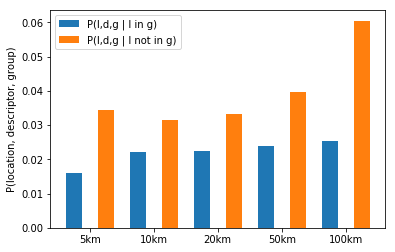

In [387]:
prob_in = []
prob_not_in = []
for p in proximity_vals:
    group_data_parses_flat_in = group_data_parses_flat[group_data_parses_flat.loc[:, 'loc_in_group_%d'%(p)]==1]
    group_data_parses_flat_not_in = group_data_parses_flat[group_data_parses_flat.loc[:, 'loc_in_group_%d'%(p)]==0]
    N_in = group_data_parses_flat_in.shape[0]
    N_not_in = group_data_parses_flat_not_in.shape[0]
    p_l_d_g_in = group_data_parses_flat_in[group_data_parses_flat_in.loc[:, 'has_descriptor']].shape[0] / N_in
    p_l_d_g_not_in = group_data_parses_flat_not_in[group_data_parses_flat_not_in.loc[:, 'has_descriptor']].shape[0] / N_not_in
    prob_in.append(p_l_d_g_in)
    prob_not_in.append(p_l_d_g_not_in)
X = np.arange(len(proximity_vals))
X_offset = 0.25
bar_width = 0.25
plt.bar(X-X_offset, prob_in, width=bar_width, label='P(l,d,g | l in g)')
plt.bar(X+X_offset, prob_not_in, width=bar_width, label='P(l,d,g | l not in g)')
plt.legend(loc='upper left')
plt.ylabel('P(location, descriptor, group)')
proximity_vals_str = ['%dkm'%(x) for x in proximity_vals]
plt.xticks(X, proximity_vals_str)
plt.show()

## Re-do test

First! Let's find locations the right way: 
1. get ORG/LOC entities from NER
2. find string in tree
3. extract subtree
4. extract descriptors

Second! Do a matched comparison:

- For each location $\ell$, compare $P(d \: | \: \ell \in g)$ and $P(d \: | \: \ell \not \in g)$

In [430]:
import pandas as pd
import numpy as np
from ast import literal_eval
group_data_clean = pd.read_csv('../../data/facebook-maria/combined_group_data_es_tagged.tsv', sep='\t', index_col=False)
group_data_clean.loc[:, 'status_message_tags'] = group_data_clean.loc[:, 'status_message_tags'].apply(literal_eval)
group_data_clean.loc[:, 'status_message_tags_ne'] = group_data_clean.loc[:, 'status_message_tags_ne'].apply(literal_eval)
display(group_data_clean.head())

,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_clean,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,Estoy preocupada por mi tia vicky vazquez que ...,"[(Estoy, O), (preocupada, O), (por, O), (mi, O...","[(asma, CAUSE_OF_DEATH), (Dorado, ORGANIZATION)]",estoy preocup por mi tia vicky vazquez que des...
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34,Para alguien que lo necesite... Dale Share..A ...,"[(Para, O), (alguien, O), (que, O), (lo, O), (...","[(Share, MISC), (general, TITLE), (Hipnoterapi...",par algui que lo necesit... da le share.<ne.mi...
2,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,En apoyo al alcalde Carlos Lopez y al municipi...,"[(En, O), (apoyo, O), (a, O), (el, O), (alcald...","[(alcalde, TITLE), (Carlos Lopez, PERSON), (Do...",en apoy a el alcalde.<ne.title> carlos_lopez.<...
3,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,Pueblo de Puerto Rico no se monten en las gran...,"[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...","[(Puerto Rico, COUNTRY), (America, MISC), (Pue...",puebl de puerto_rico.<ne.country> no se mont e...
4,351272391991842,141039043205101,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,es,351272391991842_358942134558201,2017-10-11 14:37:12,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,"[(PUEBLO, O), (DE, O), (PUERTO, O), (RICO, O),...","[(Estados Unidos, COUNTRY), (Puerto Rico, COUN...",puebl de puert ric no esper ningun ayud federa...


In [423]:
import networkx as nx
def extract_full_tree(parse_list):
    """
    Extract tree from parse list.
    
    :param parse_list: list of dependency data (token, POS, head_idx, dep_type)
    :returns tree_graph: directed graph
    """
    tree = [x + [i,] for i,x in enumerate(parse_list)] # add index for bookkeeping
    tree_graph = nx.DiGraph()
    for i, dep in enumerate(tree):
#         try:
        tree_graph.add_edge(dep[2], i, pos=dep[1], name='/'.join(map(str, dep)), dep=dep)
#         except Exception as e:
#             print('bad dep %s'%(str(dep)))
#             print(e)
#             break
    return tree_graph

In [568]:
import re
group_data_parses_clean = pd.read_csv('../../data/facebook-maria/combined_group_data_es_tagged_parsed.txt', sep='\t', index_col=False, header=None)
group_data_parses_clean.columns = ['status_id', 'parse_tree']
parse_constituent_matcher = re.compile('(.+)/(.+)/(.+)/(.+)')
group_data_parses_clean.loc[:, 'parse_tree'] = group_data_parses_clean.loc[:, 'parse_tree'].apply(lambda x: [list(parse_constituent_matcher.findall(x)[0]) for x in x.split(' ') if parse_constituent_matcher.search(x) is not None])
# fix numbers
group_data_parses_clean.loc[:, 'parse_tree'] = group_data_parses_clean.loc[:, 'parse_tree'].apply(lambda x: [[y[0], y[1], int(y[2]), y[3]] for y in x])
display(group_data_parses_clean.head())
## extract parse tree to get children etc.
group_data_parses_clean.loc[:, 'parse_tree_dep'] = group_data_parses_clean.loc[:, 'parse_tree'].apply(extract_full_tree)
## get NEs
group_data_parses_clean = pd.merge(group_data_parses_clean, group_data_clean.loc[:, ['status_id', 'status_message_tags', 'status_message']], on='status_id')
display(group_data_parses_clean.head())

,status_id,parse_tree
0,351272391991842_362333787552369,"[[Estoy, VERB, 1, aux], [preocupada, VERB, 1, ..."
1,351272391991842_361453717640376,"[[En, ADP, 0, root], [apoyo, NOUN, 0, pobj], [..."
2,351272391991842_358929311226150,"[[Pueblo, NOUN, 6, nsubj], [de, ADP, 0, prep],..."
3,351272391991842_358929311226150,"[[No, ADV, 2, neg], [se, PRON, 2, prt], [metan..."
4,351272391991842_357797888005959,"[[Guayama, PROPN, 0, root], [,, PUNCT, 0, p], ..."


,status_id,parse_tree,parse_tree_dep,status_message_tags,status_message
0,351272391991842_362333787552369,"[[Estoy, VERB, 1, aux], [preocupada, VERB, 1, ...","(1, 0, 2, 4, 3, 5, 6, 26, 7, 8, 10, 9, 11, 12,...","[(Estoy, O), (preocupada, O), (por, O), (mi, O...",Estoy preocupada por mi tia vicky vazquez que ...
1,351272391991842_361453717640376,"[[En, ADP, 0, root], [apoyo, NOUN, 0, pobj], [...","(0, 1, 2, 3, 4, 5, 6, 12, 7, 8, 9, 10, 11, 13)","[(En, O), (apoyo, O), (a, O), (el, O), (alcald...",En apoyo al alcalde Carlos Lopez y al municipi...
2,351272391991842_358929311226150,"[[Pueblo, NOUN, 6, nsubj], [de, ADP, 0, prep],...","(6, 0, 1, 2, 3, 4, 5, 7, 10, 8, 9, 11, 13, 12,...","[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...",Pueblo de Puerto Rico no se monten en las gran...
3,351272391991842_358929311226150,"[[No, ADV, 2, neg], [se, PRON, 2, prt], [metan...","(2, 0, 1, 3, 5, 4, 8, 6, 7, 10, 9, 11, 13, 12,...","[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...",Pueblo de Puerto Rico no se monten en las gran...
4,351272391991842_357797888005959,"[[Guayama, PROPN, 0, root], [,, PUNCT, 0, p], ...","(0, 1, 2, 3, 4, 5)","[(Guayama, LOCATION), (,, O), (Dorado, O), (,,...","Guayama, Dorado, y Piñones"


In [597]:
def extract_NEs(token_tags):
    NE_list = []
    NE_curr = []
    tag_curr = ''
    for i, (token, tag) in enumerate(token_tags):
        if(tag != 'O'):
            if(tag == tag_curr or tag_curr == ''):
                NE_curr.append(token)
        if(tag != tag_curr and tag_curr != ''):
            if(len(NE_curr) > 0):
                NE_curr = (' '.join(NE_curr), tag_curr)
                NE_list.append(NE_curr)
                NE_curr = []
            if(tag != 'O'):
                NE_curr.append(token)
        tag_curr = tag
    if(len(NE_curr) > 0):
        NE_curr = (' '.join(NE_curr), tag_curr)
        NE_list.append(NE_curr)
    return NE_list

def get_subtree(dep_idx, graph):
    """
    Get indices of all nodes below specified node.
    
    :param dep_idx: int
    :param graph: directed graph
    """
    dep_subtree = nx.descendants(graph, dep_idx)
    return dep_subtree

def extract_NE_subtree(status_NE, trees, tree_graphs, tree_ctr, tree_token_ctr):
    """
    Extract subtree associated with NE provided, matching
    on string and extracting the largest subtree from the NE 
    if multiple tokens.
    """
    status_NE_tokens = status_NE.split(' ')
#     print('processing status NE tokens %s'%(str(status_NE_tokens)))
    status_NE_tokens_tree = []
    status_NE_token_ctr = 0
    tree_ctr_0 = tree_ctr
    tree_token_ctr_0 = tree_token_ctr
#     print('extracting status NE tokens %s'%(str(status_NE_tokens)))
    while(len(status_NE_tokens_tree) < len(status_NE_tokens) and tree_ctr < len(trees)):
        curr_tree = trees[tree_ctr]
        curr_tree_graph = tree_graphs[tree_ctr]
        if(tree_token_ctr == len(curr_tree)):
            print('error with status NE %s'%(str(status_NE_tokens)))
            print('error at curr tree %s'%(str(curr_tree)))
            print('prev tree %s'%(str(trees[tree_ctr-1])))
            print('next tree %s'%(str(trees[tree_ctr+1])))
            print('original tree %s'%(trees[tree_ctr_0]))
        curr_tree_dep = curr_tree[tree_token_ctr]
        if(curr_tree_dep[0] == status_NE_tokens[status_NE_token_ctr]):
#             print('adding curr dep %s at tree=%d, token=%d'%(str(curr_tree_dep), tree_ctr, tree_token_ctr))
            status_NE_tokens_tree.append(curr_tree_dep)
            status_NE_token_ctr += 1
        elif(len(status_NE_tokens_tree) > 0):
            status_NE_tokens_tree = []
            status_NE_token_ctr = 0
        tree_token_ctr += 1
        # if we already have some NE tokens collected
        # then just break
        if(tree_token_ctr == len(trees[tree_ctr])):
            if(len(status_NE_tokens) > 0):
                break
            # if we still don't have NE tokens collected
            # then advance the tree
            else:
                tree_ctr += 1
                tree_token_ctr = 0
    # if we haven't found any subtrees,
    # reset tree/token counter
    if(len(status_NE_tokens_tree) == 0):
        tree_ctr = tree_ctr_0
        tree_token_ctr = tree_token_ctr_0
        status_NE_tokens_subtree = []
    else:
        # now that we have all NE tokens accounted for,
        # get subtrees for each token and
        # choose minimal subtree (i.e. doesn't contain NE)
    #     curr_tree_graph = tree_graphs[tree_ctr]
    #     print('extracted status NE tokens tree %s from tree %s'%(str(status_NE_tokens_tree), str(curr_tree)))
    #     print('status NE_tokens_tree %s'%(str(status_NE_tokens_tree)))
#         try:
        status_NE_tokens_dep_subtrees = [get_subtree(x[4], curr_tree_graph) for x in status_NE_tokens_tree]
#         except Exception as e:
#             print('graph error %s'%(e))
#             print('curr_tree_graph %s'%(list(curr_tree_graph.edges())))
#             print('previous tree %s'%(trees[tree_ctr-1]))
#             print('previous tree graph %s'%(list(tree_graphs[tree_ctr-1].edges())))
#             print('status_NE_tokens_tree %s'%(str(status_NE_tokens_tree)))
#         if(len(status_NE_tokens_dep_subtrees) == 0):
#             print('no subtrees for status NE tokens %s, status NE tree %s'%(str(status_NE_tokens), str(status_NE_tokens_tree)))
    #     print('got subtrees %s'%(str(status_NE_tokens_dep_subtrees)))
        status_NE_tokens_tree_idx = max(status_NE_tokens_dep_subtrees, key=lambda x: len(x))
        status_NE_tokens_subtree = [x for x in curr_tree if x[4] in status_NE_tokens_tree_idx]
        # remove NE from subtree
        status_NE_tokens_tree_idx = [x[4] for x in status_NE_tokens_tree]
    #     print('status NE idx %s'%(str(status_NE_tokens_tree_idx)))
        status_NE_tokens_subtree = [x for x in status_NE_tokens_subtree if x[4] not in status_NE_tokens_tree_idx]
        # fix tree/token counter if we've hit the end
        if(tree_token_ctr >= len(trees[tree_ctr])):
            tree_ctr += 1
            tree_token_ctr = 0
    return status_NE_tokens_subtree, tree_ctr, tree_token_ctr

def extract_all_NE_subtrees(status_message_tags, status_parse_trees, status_parse_tree_graphs, NE_types=None):
    """
    Collect contiguous location NEs from tags, 
    find matching string in tree, then collect
    biggest subtree in sequence for each NE.
    
    :param status_message_tags: all tags in status
    :param status_parse_trees: all parse trees (as list of dependencies)
    :param status_parse_tree_graphs: all parse trees (as directed graph)
    :param NE_types: NE types allowed (e.g. only LOCATION)
    :returns NE_subtrees: NE and subtrees
    """
#     print("processing trees %s"%(str(status_parse_trees)))
    NE_subtrees = []
#     print('parsing tags %s'%(str(status_message_tags)))
    status_NEs = extract_NEs(status_message_tags)
    if(len(status_NEs) > 0):
        if(NE_types is not None):
            status_NEs = [x for x in status_NEs if x[1] in NE_types]
#         if('HELPPR' in [x[0] for x in status_NEs]):
#             print("extracted status NEs %s"%(str(status_NEs)))
        tree_ctr = 0
        tree_token_ctr = 0
        # add idx to parse trees
        status_parse_trees = [[y + [i,] for i,y in enumerate(x)] for x in status_parse_trees]
        for status_NE in status_NEs:
    #         print('processing status NE %s'%(str(status_NE)))
            status_NE_str = status_NE[0]
#             if(status_NE_str == 'HELPPR'):
#                 print('tree=%s tree_token=%d/%d'%(status_parse_trees[tree_ctr], tree_token_ctr, len(status_parse_trees[tree_ctr])))
            NE_subtree, tree_ctr, tree_token_ctr = extract_NE_subtree(status_NE_str, status_parse_trees, status_parse_tree_graphs, tree_ctr, tree_token_ctr)
            NE_subtrees.append((status_NE, NE_subtree))
    return NE_subtrees

## test extract NEs
# test_token_tags = group_data_parses_clean.loc[:, 'status_message_tags'].values[20]
# print(test_token_tags)
# test_token_tags_NE = extract_NEs(test_token_tags)
# print(test_token_tags_NE)
## test extract parse

## test extract NE subtree
# test_tag_parse_data = group_data_parses_clean[group_data_parses_clean.loc[:, 'status_id'] == '351272391991842_358929311226150']
# test_token_tags = test_tag_parse_data.loc[:, 'status_message_tags'].values[0]
# test_parse_trees = test_tag_parse_data.loc[:, 'parse_tree'].values
# # add idx
# test_parse_trees = [[y + [i,] for i, y in enumerate(x)] for x in test_parse_trees]
# test_parse_tree_graphs = test_tag_parse_data.loc[:, 'parse_tree_dep'].values
# test_status_NE = extract_NEs(test_token_tags)
# print(test_tag_parse_data)

## fake data
# test_status_NE_tags = [('Puerto', 'COUNTRY'), ('Rico', 'COUNTRY')]
# test_status_NE = [('Puerto Rico', 'COUNTRY')]
# test_parse_trees = [[('Puerto', 'PROPN', 0, 'appos', 0), ('Rico', 'PROPN', 0, 'appos', 1), ('en', 'PREP', 1, 'appos', 2), ('el', 'det', 2, 'appos', 3)]]
# test_parse_tree_graphs = [nx.DiGraph([(y[2], y[4]) for y in x]) for x in test_parse_trees]
# print(nx.descendants(test_parse_tree_graphs[0], 1))
## test subtree extraction
# tree_ctr = 0
# tree_token_ctr = 0
# for test_status_NE_i in test_status_NE:
#     print('testing NE %s'%(test_status_NE_i[0]))
#     NE_subtree, tree_ctr, tree_token_ctr = extract_NE_subtree(test_status_NE_i[0], test_parse_trees, test_parse_tree_graphs, tree_ctr, tree_token_ctr)
#     print('extracted subtree for NE %s'%(test_status_NE_i[0]))
#     print(NE_subtree)
# NE_subtrees = extract_all_NE_subtrees(test_status_NE_tags, test_parse_trees, test_parse_tree_graphs)
# print('extracted NE subtrees for status NE %s'%(str(test_status_NE)))
# print(NE_subtrees)

from nltk.tokenize import sent_tokenize
def align_parses_txt(txt, parse_trees, parse_trees_dep, sent_tokenizer, tokenizer):
    """
    Align parse trees with text. 
    
    :param txt: original text
    :param parse_trees: parse trees
    :param parse_trees_dep: parse tree dependency graphs
    """
    # hack: tokenize text, find sentence with max overlap
    txt_sents = [tokenizer.tokenize(x) for x in sent_tokenizer.tokenize(txt)]
    txt_sent_counts = [pd.Series(x).value_counts() for x in txt_sents]
#     print('txt sents %s'%(str(txt_sents)))
#     print('txt sent counts %s'%(txt_sent_counts))
#     if(len(txt_sents) != len(parse_trees)):
#         print('mismatch between text sents %s'%(str(txt_sents)))
#         print('and parse trees %s'%(str(parse_trees)))
    parse_idx_ordered = []
    for parse_tree in parse_trees:
        parse_tokens = [x[0] for x in parse_tree]
        # clean tokens
        parse_tokens = [clean_raw_txt([x])[0] for x in parse_tokens]
        parse_token_counts = pd.Series(parse_tokens).value_counts().astype(float)
#         print('parse tokens %s'%(str(parse_tokens)))
#         print('parse token counts %s'%(parse_token_counts))
#         for x in txt_sent_counts:
#             print('txt_sent_count %s'%(x))
#             print(x - parse_token_counts)
        txt_diff_pcts = [(i, (x - parse_token_counts).fillna(1).sum() / (x.sum() + parse_token_counts.sum())) for i, x in enumerate(txt_sent_counts)]
#         if('helppr' in parse_token_counts.index):
#             print('testing txt diff pcts %s'%(txt_diff_pcts))
#             print('testing parse token counts %s'%(str(parse_token_counts)))
#             print('testing txt token counts %s'%(str(txt_sent_counts)))
#         if(len(txt_diff_pcts) == 0):
#             print('no more indices available for %d parse trees and %d sentences'%(len(parse_trees), len(txt_sents)))
#         print('overlap pcts %s'%(txt_diff_pcts))
        parse_idx = min(txt_diff_pcts, key=lambda x: x[0])[0]
        parse_idx = np.argmin(txt_diff_pcts)
        bad_parse_idx = []
        while(parse_idx >= len(parse_trees)):
            bad_parse_idx.append(parse_idx)
            txt_diff_pcts = [(i, (x - parse_token_counts).fillna(1).sum() / (x.sum() + parse_token_counts.sum())) for i, x in enumerate(txt_sent_counts) if i not in bad_parse_idx+parse_idx_ordered]
            parse_idx = min(txt_diff_pcts, key=lambda x:x[0])[0]
            print('new parse idx %d'%(parse_idx))
#         print('parse idx %d'%(parse_idx))
        parse_idx_ordered.append(parse_idx)
    if(max(parse_idx_ordered) >= len(parse_trees)):
        print('bad parse idx %s'%(str(parse_idx_ordered)))
    parse_trees = [parse_trees[i] for i in parse_idx_ordered]
    parse_trees_dep = [parse_trees_dep[i] for i in parse_idx_ordered]
    return parse_trees, parse_trees_dep

## test alignment
# test_txt = 'yo quiero hacer eso. yo quiero comer uno taco.'
# test_txt_sents = sent_tokenizer.tokenize(test_txt)
# print(test_txt_sents)
# test_parse_trees = list(reversed([[[y,0] for y in tokenizer.tokenize(x)] for x in test_txt_sents]))
# test_parse_trees_dep = list(reversed([[[y,0] for y in tokenizer.tokenize(x)] for x in test_txt_sents]))
# print('initial parses %s'%(str(test_parse_trees)))
# print('initial parses dep %s'%(str(test_parse_trees_dep)))
# test_parse_trees, test_parse_trees_dep = align_parses_txt(test_txt, test_parse_trees, test_parse_trees_dep, sent_tokenizer, tokenizer)
# print('aligned parses %s'%(test_parse_trees))

## real data
## tokenizers for alignment
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from data_helpers import clean_raw_txt # need to clean text to match parses
sent_tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')
tokenizer = ToktokTokenizer()

group_data_parses_clean_NE_subtrees = []
for i, (status_i, status_data_i) in enumerate(group_data_parses_clean.groupby('status_id')):
    status_txt_i = status_data_i.loc[:, 'status_message'].values[0]
    status_txt_i_clean = clean_raw_txt([status_txt_i])[0]
    status_tags_i = status_data_i.loc[:, 'status_message_tags'].values[0]
    status_parse_trees_i = status_data_i.loc[:, 'parse_tree'].values
    status_parse_trees_dep_i = status_data_i.loc[:, 'parse_tree_dep'].values
#     if('HELPPR' in status_txt_i):
#         print('pre-align bad parse trees %s'%(str(status_parse_trees_i)))
#         print('pre-align text sents %s'%(str(sent_tokenizer.tokenize(status_txt_i_clean))))
    # align parses!
#     status_parse_trees_i, status_parse_trees_dep_i = align_parses_txt(status_txt_i_clean, status_parse_trees_i, status_parse_trees_dep_i, sent_tokenizer, tokenizer)
#     if('HELPPR' in status_txt_i):
#         print('possible bad parse trees %s'%(str(status_parse_trees_i)))
    NE_subtrees_i = extract_all_NE_subtrees(status_tags_i, status_parse_trees_i, status_parse_trees_dep_i)
    group_data_parses_clean_NE_subtrees.append(NE_subtrees_i)
    if(i % 1000 == 0):
        print('processed %d status groups'%(i))

processed 0 status groups
processed 1000 status groups
processed 2000 status groups
processed 3000 status groups
processed 4000 status groups
processed 5000 status groups
processed 6000 status groups
processed 7000 status groups
processed 8000 status groups
processed 9000 status groups
processed 10000 status groups
processed 11000 status groups
processed 12000 status groups
processed 13000 status groups
processed 14000 status groups
processed 15000 status groups
processed 16000 status groups
processed 17000 status groups
processed 18000 status groups
processed 19000 status groups
processed 20000 status groups
processed 21000 status groups
processed 22000 status groups


In [720]:
a = pd.DataFrame()
a.loc[:, 'a'] = [1]
print(NE_subtree_i_j[1])
b = pd.Series([NE_subtree_i_j[1]])
print(b)
a.loc[:, 'b'] = b
print(a)

[[',', 'PUNCT', 10, 'p', 9], [',', 'PUNCT', 10, 'p', 13], ['Leilani', 'PROPN', 10, 'conj', 14], ['Rios', 'PROPN', 14, 'nn', 15], [',', 'PUNCT', 10, 'p', 16], ['Sher', 'PROPN', 10, 'conj', 17], ['Rios', 'PROPN', 17, 'nn', 18], [',', 'PUNCT', 10, 'p', 19], ['Raquel', 'PROPN', 10, 'conj', 20], ['Robles', 'PROPN', 20, 'nn', 21], [',', 'PUNCT', 10, 'p', 22], ['Raquel', 'PROPN', 10, 'conj', 23], ['Robles', 'PROPN', 23, 'nn', 24], ['Miranda', 'PROPN', 23, 'nn', 25], [',', 'PUNCT', 10, 'p', 26]]
0    [[,, PUNCT, 10, p, 9], [,, PUNCT, 10, p, 13], ...
dtype: object
   a                                                  b
0  1  [[,, PUNCT, 10, p, 9], [,, PUNCT, 10, p, 13], ...


In [722]:
# %%timeit
# from time import time
## combine subtrees with rest of data
## one subtree at a time
group_data_parses_clean_NE_subtrees_data = []
for i, (status_i, status_data) in enumerate(group_data_parses_clean.groupby('status_id')):
    status_data_i = status_data.drop_duplicates('status_id', inplace=False)
#     print('%d status data'%(status_data_i.shape[0]))
    NE_subtrees_i = group_data_parses_clean_NE_subtrees[i]
#     print('%d subtrees'%(len(NE_subtrees_i)))
#     print(NE_subtrees_i)
#     print('%d statuses'%(status_data.shape[0]))
    for NE_subtree_i_j in NE_subtrees_i:
        status_data_i_j = status_data_i.copy()
#         print('%d status data'%(status_data_i_j.shape[0]))
        status_data_i_j.loc[:, 'NE_name'] = NE_subtree_i_j[0][0]
        status_data_i_j.loc[:, 'NE_type'] = NE_subtree_i_j[0][1]
        if(len(NE_subtree_i_j[1]) > 0):
            status_data_i_j.loc[:, 'NE_tree'] = pd.Series([NE_subtree_i_j[1]], index=status_data_i_j.index)
        status_data_i_j.drop(['parse_tree_dep', 'status_message', 'status_message_tags'], axis=1, inplace=True)
        group_data_parses_clean_NE_subtrees_data.append(status_data_i_j)
    if(i % 1000 == 0):
        print('processed %d status groups'%(i))
group_data_parses_clean_NE_subtrees_ = pd.concat(group_data_parses_clean_NE_subtrees_data, axis=0)
display(group_data_parses_clean_NE_subtrees_.head())

processed 0 status groups
processed 1000 status groups
processed 2000 status groups
processed 3000 status groups
processed 4000 status groups
processed 5000 status groups
processed 6000 status groups
processed 7000 status groups
processed 8000 status groups
processed 9000 status groups
processed 10000 status groups
processed 11000 status groups
processed 12000 status groups
processed 13000 status groups
processed 14000 status groups
processed 15000 status groups
processed 16000 status groups
processed 17000 status groups
processed 18000 status groups
processed 19000 status groups
processed 20000 status groups
processed 21000 status groups
processed 22000 status groups


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,NE_name,NE_tree,NE_type,parse_tree,status_id
129,Maunabo,"[[qué, DET, 15, det, 14]]",ORGANIZATION,"[[Lo, DET, 1, det], [que, PRON, 3, dobj], [ten...",105121436871597_105122476871493
130,Maunabo,NaN,LOCATION,"[[Mi, PRON, 1, det], [gente, NOUN, 2, attr], [...",105121436871597_105140713536336
131,PR,NaN,ORGANIZATION,"[[Artículos, NOUN, 0, root], [que, PRON, 4, ns...",105121436871597_105141490202925
131,Gracias,NaN,MISC,"[[Artículos, NOUN, 0, root], [que, PRON, 4, ns...",105121436871597_105141490202925
131,3,NaN,NUMBER,"[[Artículos, NOUN, 0, root], [que, PRON, 4, ns...",105121436871597_105141490202925


In [727]:
print('%d/%d mentions with subtree'%(group_data_parses_clean_NE_subtrees_[~group_data_parses_clean_NE_subtrees_.loc[:, 'NE_tree'].apply(lambda x: type(x) is float and np.isnan(x))].shape[0], group_data_parses_clean_NE_subtrees_.shape[0]))
# get type distribution
entity_type_counts = group_data_parses_clean_NE_subtrees_.loc[:, 'NE_type'].value_counts()
print(entity_type_counts.head(10))

16917/67666 mentions with subtree
PERSON            22317
ORGANIZATION      13819
LOCATION          10591
MISC               6288
CITY               4335
NUMBER             4016
DATE               1694
COUNTRY            1514
TITLE              1324
CAUSE_OF_DEATH      557
Name: NE_type, dtype: int64


Now we'll match each `LOCATION`, `ORGANIZATION` or `CITY` to a PR location.

In [744]:
# load location data 
from unidecode import unidecode
def match_name(name, loc_data):
    name_fixed = unidecode(name.lower())
    loc_data_x = loc_data[loc_data.loc[:, 'alternate_names_fixed_regex'].apply(lambda x: x.search(name_fixed) is not None)]
    return loc_data_x
def match_loc(name, loc_data):
    loc_data_n = match_name(name, loc_data)
    if(loc_data_n.shape[0] > 0):
        loc_data_n = loc_data_n.iloc[0, :]
        lat, lon = loc_data_n.loc[['latitude', 'longitude']].values
    else:
        lat, lon = [0, 0]
    return lat, lon
def load_loc_data():
    geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False)
    parentheses_matcher = re.compile('\(.*$')
    geonames_data.loc[:, 'name'] = geonames_data.loc[:, 'name'].apply(lambda x: parentheses_matcher.sub('', x))
    geonames_data_PR = geonames_data[geonames_data.loc[:, 'country']=='PR']
    # only keep duplicates with more alternate names
    geonames_data_PR.sort_values(['name', 'alternate_name_count'], inplace=True, ascending=False)
    geonames_data_PR.drop_duplicates(['name', 'latitude', 'longitude'], keep='first', inplace=True)
    # fix alternate names
    geonames_data_PR.loc[:, 'alternate_names'] = geonames_data_PR.loc[:, 'alternate_names'].fillna('')
    geonames_data_PR.loc[:, 'alternate_names'] = geonames_data_PR.apply(lambda x: ','.join(set([x.loc['name']] + x.loc['alternate_names'].split(',')) - set([''])), axis=1)
    geonames_data_PR.loc[:, 'name_fixed'] = geonames_data_PR.loc[:, 'name'].apply(lambda x: unidecode(x.lower()))
    geonames_data_PR.loc[:, 'alternate_names_fixed'] = geonames_data_PR.loc[:, 'alternate_names'].apply(lambda x: ','.join(set(map(lambda y: unidecode(y.lower()), x.split(',')))))
    geonames_data_PR.loc[:, 'alternate_names_regex'] = geonames_data_PR.loc[:, 'alternate_names'].apply(lambda x: re.compile('|'.join(map(lambda y: '^%s$'%(y), x.split(',')))))
    geonames_data_PR.loc[:, 'alternate_names_fixed_regex'] = geonames_data_PR.loc[:, 'alternate_names_fixed'].apply(lambda x: re.compile('|'.join(map(lambda y: '^%s$'%(y), x.split(',')))))
    geonames_PR_name_counts = geonames_data_PR.loc[:, 'name_fixed'].value_counts()
    geonames_PR_unambiguous_names = list(geonames_PR_name_counts[geonames_PR_name_counts == 1].index)
    geonames_data_PR_unambiguous = geonames_data_PR[geonames_data_PR.loc[:, 'name_fixed'].isin(geonames_PR_unambiguous_names)]
    return geonames_data, geonames_data_PR, geonames_data_PR_unambiguous
geonames_data, geonames_data_PR, geonames_data_PR_unambiguous = load_loc_data()
display(geonames_data_PR_unambiguous.head())

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count,name_fixed,alternate_names_fixed,alternate_names_regex,alternate_names_fixed_regex
7739258,4562634,Área de Recreo El Yunque,"Area de Recreo El Yunque,Área de Recreo El Yunque",18.30245,-65.78572,L,PRK,PR,0,1,area de recreo el yunque,area de recreo el yunque,re.compile('^Area de Recreo El Yunque$|^Área d...,re.compile('^area de recreo el yunque$')
7739238,4562613,Ángeles,"Ángeles,Angeles",18.28495,-66.79934,P,PPL,PR,0,1,angeles,angeles,re.compile('^Ángeles$|^Angeles$'),re.compile('^angeles$')
7745471,4568936,Zona Portuaria,Zona Portuaria,18.42800,-66.10322,S,NaN,PR,0,1,zona portuaria,zona portuaria,re.compile('^Zona Portuaria$'),re.compile('^zona portuaria$')
7745470,4568935,Zona Industrial Boulevardo Maria,Zona Industrial Boulevardo Maria,18.29273,-67.13574,S,NaN,PR,0,1,zona industrial boulevardo maria,zona industrial boulevardo maria,re.compile('^Zona Industrial Boulevardo Maria$'),re.compile('^zona industrial boulevardo maria$')
7746716,7269321,Zenial Building,Zenial Building,18.43851,-66.05936,S,BLDG,PR,0,1,zenial building,zenial building,re.compile('^Zenial Building$'),re.compile('^zenial building$')


In [761]:
# match locations and groups
# NAME | GROUP | LAT/LON | GROUP LAT/LON
NE_loc_types = ['LOCATION', 'ORGANIZATION', 'CITY']
NE_mentions_valid = group_data_parses_clean_NE_subtrees_[group_data_parses_clean_NE_subtrees_.loc[:, 'NE_type'].isin(NE_loc_types)]
print('%d/%d valid NE mentions'%(NE_mentions_valid.shape[0], group_data_parses_clean_NE_subtrees_.shape[0]))
NE_mentions_valid_lat_lon = np.array([x for x in NE_mentions_valid.loc[:, 'NE_name'].apply(lambda x: match_loc(x, geonames_data_PR_unambiguous))])
NE_mentions_valid.loc[:, 'lat'] = NE_mentions_valid_lat_lon[:, 0]
NE_mentions_valid.loc[:, 'lon'] = NE_mentions_valid_lat_lon[:, 1]
NE_mentions_valid_loc = NE_mentions_valid[(NE_mentions_valid.loc[:, 'lat'] != 0) & (NE_mentions_valid.loc[:, 'lon'] != 0)]
NE_mentions_valid_loc.fillna('', inplace=True)
print('%d/%d valid LOC mentions'%(NE_mentions_valid_loc.shape[0], group_data_parses_clean_NE_subtrees_.shape[0]))

28745/67666 valid NE mentions


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


6235/67666 valid LOC mentions


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [762]:
print('%d/%d LOC mentions with subtree'%(NE_mentions_valid_loc[NE_mentions_valid_loc.loc[:, 'NE_tree'] != ''].shape[0], NE_mentions_valid_loc.shape[0]))

1054/6235 LOC mentions with subtree


All right! This is slightly bigger than before (x3).

In [754]:
# map group data to centroid
group_loc_data = pd.read_csv('../../data/facebook-maria/location_group_data.tsv', sep='\t', index_col=False)
display(group_loc_data.head())
# only 
# match location name to GeoNames ID
geonames_data_PR.sort_values(['name', 'alternate_name_count'], inplace=True, ascending=False)
group_loc_data.loc[:, 'geonames_ID'] = group_loc_data.loc[:, 'location_name'].apply(lambda x: match_name(x, geonames_data_PR).iloc[0].loc['geonames_ID'])
group_loc_data = pd.merge(group_loc_data, geonames_data_PR.loc[:, ['geonames_ID', 'latitude', 'longitude']], on='geonames_ID')
## compute centroid, loc count of each group
group_loc_data_centroids = group_loc_data.groupby('group_id').apply(lambda x: x.loc[:, ['latitude', 'longitude']].mean(axis=0))
group_loc_data_centroids = group_loc_data_centroids.reset_index(inplace=False).rename(columns={'latitude':'latitude_centroid', 'longitude':'longitude_centroid'}, inplace=False)
group_loc_data_counts = group_loc_data.loc[:, 'group_id'].value_counts().reset_index(inplace=False).rename(columns={'index':'group_id', 'group_id':'loc_count'}, inplace=False)
## combine
group_loc_data = pd.merge(group_loc_data, group_loc_data_centroids, on='group_id')
group_loc_data = pd.merge(group_loc_data, group_loc_data_counts, on='group_id')
group_loc_data_unique = group_loc_data.drop_duplicates('group_id', keep='first')
group_loc_data_unique.rename(columns={'latitude':'group_latitude', 'longitude':'group_longitude'}, inplace=True)
display(group_loc_data_unique.head())

,location_name,group_id,group_name
0,Aguada,1724474021195839,Huracan Maria Anasco y Aguada
1,Aguadilla,117529462276443,Huracan Maria Aguadilla
2,Aguadilla,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero
3,Aguas Buenas,1723084327997466,Aguas Buenas Huracan Maria
4,Aguas Buenas,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, ar..."


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,location_name,group_id,group_name,geonames_ID,group_latitude,group_longitude,latitude_centroid,longitude_centroid,loc_count
0,Aguada,1724474021195839,Huracan Maria Anasco y Aguada,4562502,18.37939,-67.18824,18.331060,-67.16393,2
2,Aguadilla,117529462276443,Huracan Maria Aguadilla,4562506,18.42745,-67.15407,18.427450,-67.15407,1
3,Aguadilla,1390525734396603,Huracan Maria - Aguadilla - Ceiba Baja y Guerrero,4562506,18.42745,-67.15407,18.343980,-66.41295,2
5,Aguas Buenas,1723084327997466,Aguas Buenas Huracan Maria,4562516,18.25690,-66.10294,18.256900,-66.10294,1
6,Aguas Buenas,210130182858104,"Huracán María Comerío Bayamón Aguas Buenas, ar...",4562516,18.25690,-66.10294,18.227318,-66.09558,4


In [833]:
from geopy.distance import great_circle
# combine mentions with group data
NE_mentions_valid_loc_group = pd.merge(NE_mentions_valid_loc, group_data.loc[:, ['group_id', 'status_id']].drop_duplicates('status_id', inplace=False), on='status_id')
NE_mentions_valid_loc_group = pd.merge(NE_mentions_valid_loc_group, group_loc_data_unique.loc[:, ['group_id', 'group_latitude', 'group_longitude']], on='group_id')
# compute distance
NE_mentions_valid_loc_group.loc[:, 'dist'] = NE_mentions_valid_loc_group.apply(lambda x: great_circle(x.loc[['lat', 'lon']].values, x.loc[['group_latitude', 'group_longitude']].values).kilometers, axis=1)
distance_vals = [5, 10, 20, 50]
for k in distance_vals:
    NE_mentions_valid_loc_group.loc[:, 'dist_%d'%(k)] = (NE_mentions_valid_loc_group.loc[:, 'dist'] <= k).astype(int)
display(NE_mentions_valid_loc_group.head(10))

,NE_name,NE_tree,NE_type,parse_tree,status_id,lat,lon,group_id,group_latitude,group_longitude,dist,dist_5,dist_10,dist_20,dist_50
0,Maunabo,"[[qué, DET, 15, det, 14]]",ORGANIZATION,"[[Lo, DET, 1, det], [que, PRON, 3, dobj], [ten...",105121436871597_105122476871493,18.01691,-65.92738,105121436871597,18.01691,-65.92738,0.000000,1,1,1,1
1,Maunabo,,LOCATION,"[[Mi, PRON, 1, det], [gente, NOUN, 2, attr], [...",105121436871597_105140713536336,18.01691,-65.92738,105121436871597,18.01691,-65.92738,0.000000,1,1,1,1
2,Manati,,CITY,"[[Buen, ADJ, 1, amod], [dia, NOUN, 1, root], [...",1103661653103604_1104125946390508,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1
3,Mar Chiquita,,LOCATION,"[[Alguien, PRON, 1, nsubj], [tiene, VERB, 1, r...",1103661653103604_1104391413030628,18.47383,-66.48517,1103661653103604,18.41884,-66.49267,6.165583,0,1,1,1
4,Manati,,CITY,"[[Por, ADP, 10, prep], [si, ADP, 5, mark], [al...",1103661653103604_1104468859689550,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1
5,Manati,,CITY,"[[Estoy, VERB, 1, aux], [buscando, VERB, 1, ro...",1103661653103604_1104696119666824,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1
6,Manati,,CITY,"[[Alguien, PRON, 3, nsubj], [me, PRON, 3, iobj...",1103661653103604_1104934632976306,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1
7,el Pueblo,,CITY,"[[Donde, ADV, 1, advmod], [estan, VERB, 1, roo...",1103661653103604_1106089096194193,18.30301,-65.30099,1103661653103604,18.41884,-66.49267,126.420618,0,0,0,0
8,manati,,CITY,"[[Gracias, NOUN, 2, aux], [por, ADP, 0, mwe], ...",1103661653103604_1106702009466235,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1
9,Manati,,CITY,"[[Amig@s, NOUN, 0, root], [,, PUNCT, 0, p], [l...",1103661653103604_1106925839443852,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1


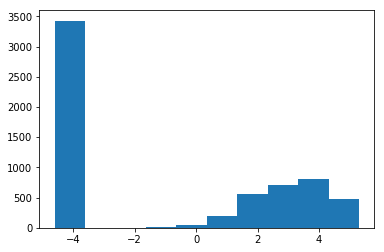

In [834]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(np.log(NE_mentions_valid_loc_group.loc[:, 'dist'].values+1e-2))
plt.show()

In [835]:
# what kinds of dependency categories do we have in the first part of the subtree?
def get_most_immediate_children(tree):
    """
    Get most immediate children to mention string
    based on head index.
    """
    subtree_head_idx = min(tree, key=lambda x: x[2])[2]
    subtree = [x for x in tree if x[2]==subtree_head_idx]
    return subtree
NE_mentions_valid_loc_group_tree = NE_mentions_valid_loc_group[NE_mentions_valid_loc_group.loc[:, 'NE_tree']!='']
dep_category_counts = []
for x in NE_mentions_valid_loc_group_tree.loc[:, 'NE_tree']:
#     print(x)
#     break
    for c in get_most_immediate_children(x):
        dep_category_counts.append(c[3])
dep_category_counts = pd.Series(dep_category_counts).value_counts()
# dep_category_counts = NE_mentions_valid_loc_group_tree.loc[:, 'NE_tree'].apply(lambda x: x[0][3]).value_counts()
print(dep_category_counts)
# NE_mentions_valid_loc_group_tree.head(20)

p            440
nn           377
conj         358
det          233
appos        197
cc           172
prep         162
amod          74
advmod        39
rcmod         35
vmod          11
parataxis     10
dep            9
num            5
prt            4
advcl          4
goeswith       3
pobj           2
predet         1
foreign        1
mwe            1
root           1
dtype: int64


In [836]:
# add descriptor data
NE_mentions_valid_loc_group.loc[:, 'has_subtree'] = (NE_mentions_valid_loc_group.loc[:, 'NE_tree'] != '').astype(int)
DESCRIPTOR_CHILD_CATEGORIES = ['relcl', 'acl', 'appos', 'amod', 'prep', 'det']
NE_mentions_valid_loc_group.loc[:, 'has_descriptor_subtree'] = NE_mentions_valid_loc_group.loc[:, 'NE_tree'].apply(lambda x: x != '' and len([x[3] for x in get_most_immediate_children(x) if x[3] in DESCRIPTOR_CHILD_CATEGORIES]) > 0).astype(int)
print('%d/%d mentions with descriptor category'%(NE_mentions_valid_loc_group.loc[:, 'has_descriptor_subtree'].sum(), NE_mentions_valid_loc_group.shape[0]))

530/6235 mentions with descriptor category


Now! Let's separate the string mentions by in-group and not-in-group, and do a paired comparison on strings.

In [837]:
NE_mentions_paired = []
NE_mentions_valid_loc_group.loc[:, 'NE_name_fixed'] = NE_mentions_valid_loc_group.loc[:, 'NE_name'].apply(lambda x: unidecode(x.lower()))
k_val = 5
for NE_str, NE_data in NE_mentions_valid_loc_group.groupby('NE_name_fixed'):
    # pair not-in-group with in-group
    NE_data_not_in_group = NE_data[NE_data.loc[:, 'dist_%d'%(k)]==1]
    NE_data_in_group = NE_data[NE_data.loc[:, 'dist_%d'%(k)]==0]
    if(NE_data_not_in_group.shape[0] > 0 and NE_data_in_group.shape[0] > 0):
        NE_mentions_paired.append(NE_data)
NE_mentions_paired = pd.concat(NE_mentions_paired, axis=0)
print('%d unique paired names (N=%d)'%(NE_mentions_paired.loc[:, 'NE_name_fixed'].nunique(), NE_mentions_paired.shape[0]))
NE_mentions_paired.loc[:, 'NE_name_fixed'].value_counts()

95 unique paired names (N=4643)


guayama                 884
coamo                   512
quebradillas            344
yabucoa                 316
cidra                   248
corozal                 244
utuado                  164
ponce                   137
lajas                   127
patillas                120
bayamon                 111
mayaguez                108
isabela                 102
caguas                   91
corazon                  71
aguadilla                66
el carmen                52
carolina                 50
arecibo                  45
humacao                  43
manati                   42
madrid                   41
santiago                 33
el valle                 31
camuy                    29
parguera                 26
guardia nacional         25
iglesia                  23
palmas                   23
rincon                   23
                       ... 
guayanilla                6
san sebastian             5
cantera                   5
buenaventura              5
galateo             

- $H_{0}: P(d | l \in g) = P(d | l \not \in g)$
- $H_{1}: P(d | l \in g) < P(d | l \not \in g)$

P(d) = 0.085
paired test
testing k=5
P(d | l \in g) = 0.052
P(d | l \not \in g) = 0.094
diff=-0.042, test stat=-5.469 (p=2.257E-08)
testing k=10
P(d | l \in g) = 0.052
P(d | l \not \in g) = 0.099
diff=-0.046, test stat=-5.773 (p=3.888E-09)
testing k=20
P(d | l \in g) = 0.055
P(d | l \not \in g) = 0.105
diff=-0.050, test stat=-5.553 (p=1.405E-08)
testing k=50
P(d | l \in g) = 0.058
P(d | l \not \in g) = 0.125
diff=-0.068, test stat=-5.908 (p=1.734E-09)


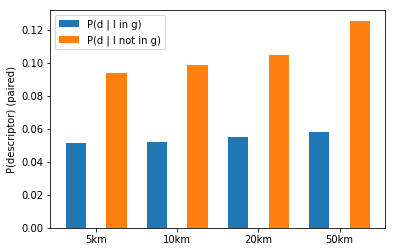

unpaired test
testing k=5
P(d | l \in g) = 0.056
P(d | l \not \in g) = 0.130
diff=-0.074, test stat=-10.277 (p=4.476E-25)
testing k=10
P(d | l \in g) = 0.057
P(d | l \not \in g) = 0.143
diff=-0.086, test stat=-11.410 (p=1.859E-30)
testing k=20
P(d | l \in g) = 0.060
P(d | l \not \in g) = 0.163
diff=-0.104, test stat=-12.587 (p=1.239E-36)
testing k=50
P(d | l \in g) = 0.070
P(d | l \not \in g) = 0.183
diff=-0.113, test stat=-10.903 (p=5.590E-28)


In [846]:
from scipy.stats import norm
def binomial_test(p1, p2, n1, n2):
    p_pool = (n1*p1 + n2*p2) / (n1 + n2)
    # compute z-score: (p1 - p2) / (p(1-p) (1/n1 + 1/n2))**2
    Z = (p1 - p2) / (p_pool*(1-p_pool)*(1/n1 + 1/n2))**.5
    p_val = norm.cdf(Z)
    return Z, p_val
    
p_desc = NE_mentions_valid_loc_group.loc[:, 'has_descriptor_subtree'].sum() / NE_mentions_valid_loc_group.shape[0]
print('P(d) = %.3f'%(p_desc))
distance_vals = [5, 10, 20, 50]

## paired test
print('paired test')
p_l_in_g_paired = []
p_l_not_in_g_paired = []
for k in distance_vals:
    print('testing k=%d'%(k))
    NE_mentions_paired_in_g = NE_mentions_paired[NE_mentions_paired.loc[:, 'dist_%d'%(k)]==1]
    NE_mentions_paired_not_in_g = NE_mentions_paired[NE_mentions_paired.loc[:, 'dist_%d'%(k)]==0]
    N_in_g = NE_mentions_paired_in_g.shape[0]
    N_not_in_g = NE_mentions_paired_not_in_g.shape[0]
    p_l_in_g = NE_mentions_paired_in_g.loc[:, 'has_descriptor_subtree'].sum() / N_in_g
    p_l_not_in_g = NE_mentions_paired_not_in_g.loc[:, 'has_descriptor_subtree'].sum() / N_not_in_g
    print('P(d | l \\in g) = %.3f'%(p_l_in_g))
    print('P(d | l \\not \\in g) = %.3f'%(p_l_not_in_g))
    p_diff = p_l_in_g - p_l_not_in_g
    test_stat, p_val = binomial_test(p_l_in_g, p_l_not_in_g, N_in_g, N_not_in_g)
    print('diff=%.3f, test stat=%.3f (p=%.3E)'%(p_diff, test_stat, p_val))
    p_l_in_g_paired.append(p_l_in_g)
    p_l_not_in_g_paired.append(p_l_not_in_g)
# plot P(d | l \in g) vs. P(d | l \not \in g)
X = np.arange(len(distance_vals))
X_offset = 0.25
bar_width = 0.25
plt.bar(X-X_offset, p_l_in_g_paired, width=bar_width, label='P(d | l in g)')
plt.bar(X+X_offset, p_l_not_in_g_paired, width=bar_width, label='P(d | l not in g)')
plt.legend(loc='upper left')
plt.ylabel('P(descriptor) (paired)')
distance_vals_str = ['%dkm'%(x) for x in distance_vals]
plt.xticks(X, distance_vals_str)
plt.show()

## unpaired test
print('unpaired test')
for k in distance_vals:
    print('testing k=%d'%(k))
    NE_mentions_paired_in_g = NE_mentions_valid_loc_group[NE_mentions_valid_loc_group.loc[:, 'dist_%d'%(k)]==1]
    NE_mentions_paired_not_in_g = NE_mentions_valid_loc_group[NE_mentions_valid_loc_group.loc[:, 'dist_%d'%(k)]==0]
    N_in_g = NE_mentions_paired_in_g.shape[0]
    N_not_in_g = NE_mentions_paired_not_in_g.shape[0]
    p_l_in_g = NE_mentions_paired_in_g.loc[:, 'has_descriptor_subtree'].sum() / N_in_g
    p_l_not_in_g = NE_mentions_paired_not_in_g.loc[:, 'has_descriptor_subtree'].sum() / N_not_in_g
    print('P(d | l \\in g) = %.3f'%(p_l_in_g))
    print('P(d | l \\not \\in g) = %.3f'%(p_l_not_in_g))
    p_diff = p_l_in_g - p_l_not_in_g
    test_stat, p_val = binomial_test(p_l_in_g, p_l_not_in_g, N_in_g, N_not_in_g)
    print('diff=%.3f, test stat=%.3f (p=%.3E)'%(p_diff, test_stat, p_val))

OK! The paired tests have a slightly weaker effect which makes sense (less variance) but the overall effect is the same: 

$$P(d | l \in g) < P(d | l \not \in g)$$

Let's do a more careful test on the paired data: for each location $l$, compute the probability of descriptor for in-group and out-group, take the difference, and compute the mean probability over all locations.

In [839]:
from scipy.stats import ttest_rel
for k in distance_vals:
    print('testing k=%d'%(k))
    p_l_in_g_list = []
    p_l_not_in_g_list = []
    for NE_str, NE_data in NE_mentions_paired.groupby('NE_name_fixed'):        
        NE_in_g = NE_data[NE_data.loc[:, 'dist_%d'%(k)]==1]
        NE_not_in_g = NE_data[NE_data.loc[:, 'dist_%d'%(k)]==0]
        N_in_g = NE_data.shape[0]
        N_not_in_g = NE_data.shape[0]
        p_l_in_g = NE_in_g.loc[:, 'has_descriptor_subtree'].sum() / N_in_g
        p_l_not_in_g = NE_not_in_g.loc[:, 'has_descriptor_subtree'].sum() / N_not_in_g
        p_l_in_g_list.append(p_l_in_g)
        p_l_not_in_g_list.append(p_l_not_in_g)
    p_l_in_g = np.mean(p_l_in_g_list)
    p_l_not_in_g = np.mean(p_l_not_in_g_list)
    print('P(d | l \\in g) = %.3f'%(p_l_in_g))
    print('P(d | l \\not \\in g) = %.3f'%(p_l_not_in_g))
    test_stat, p_val = ttest_rel(p_l_in_g_list, p_l_not_in_g_list)
    print('t-test stat %.3f (p=%.3E)'%(test_stat, p_val))

testing k=5
P(d | l \in g) = 0.019
P(d | l \not \in g) = 0.131
t-test stat -4.709 (p=8.567E-06)
testing k=10
P(d | l \in g) = 0.021
P(d | l \not \in g) = 0.128
t-test stat -4.483 (p=2.073E-05)
testing k=20
P(d | l \in g) = 0.042
P(d | l \not \in g) = 0.108
t-test stat -2.722 (p=7.740E-03)
testing k=50
P(d | l \in g) = 0.085
P(d | l \not \in g) = 0.065
t-test stat 1.209 (p=2.299E-01)


Again, effects aren't as strong but the overall picture is the same:

$$P(d | l \in g) < P(d | l \not \in g)$$

### Compare descriptors across FB users
Naturally this local/non-local distinction leads to another hypothesis: do FB group members modulate their use of descriptors (i.e. use descriptors in non-local groups, omit descriptors in local groups)?

We need the same data as before but segmented by user.

Let's join the NE mention data with the original status data to get user ID.

In [878]:
# write data to file for easy reboot
NE_mentions_valid_loc_group.to_csv('../../data/facebook-maria/combined_group_data_es_ne_geoloc_parsed_flat.tsv', sep='\t', index=False)

In [849]:
combined_group_data = pd.read_csv('../../data/facebook-maria/combined_group_data.tsv', sep='\t', index_col=False)
display(combined_group_data.head())

,group_id,status_author_id,status_message,status_lang,status_id,status_published
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34
2,351272391991842,10215020607489848,One unsafe well in Dorado on Carr 694 km 4.5,en,351272391991842_361487960970285,2017-10-17 20:20:03
3,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08
4,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22


In [850]:
combined_NE_user_data = pd.merge(NE_mentions_valid_loc_group, combined_group_data.loc[:, ['status_id', 'status_author_id']], on='status_id')
display(combined_NE_user_data.head())

,NE_name,NE_tree,NE_type,parse_tree,status_id,lat,lon,group_id,group_latitude,group_longitude,dist,dist_5,dist_10,dist_20,dist_50,has_subtree,has_descriptor_subtree,NE_name_fixed,status_author_id
0,Maunabo,"[[qué, DET, 15, det, 14]]",ORGANIZATION,"[[Lo, DET, 1, det], [que, PRON, 3, dobj], [ten...",105121436871597_105122476871493,18.01691,-65.92738,105121436871597,18.01691,-65.92738,0.000000,1,1,1,1,1,1,maunabo,10155826475814621
1,Maunabo,,LOCATION,"[[Mi, PRON, 1, det], [gente, NOUN, 2, attr], [...",105121436871597_105140713536336,18.01691,-65.92738,105121436871597,18.01691,-65.92738,0.000000,1,1,1,1,0,0,maunabo,10155826475814621
2,Manati,,CITY,"[[Buen, ADJ, 1, amod], [dia, NOUN, 1, root], [...",1103661653103604_1104125946390508,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1,0,0,manati,10155395198238347
3,Mar Chiquita,,LOCATION,"[[Alguien, PRON, 1, nsubj], [tiene, VERB, 1, r...",1103661653103604_1104391413030628,18.47383,-66.48517,1103661653103604,18.41884,-66.49267,6.165583,0,1,1,1,0,0,mar chiquita,10155834090713114
4,Manati,,CITY,"[[Por, ADP, 10, prep], [si, ADP, 5, mark], [al...",1103661653103604_1104468859689550,18.41884,-66.49267,1103661653103604,18.41884,-66.49267,0.000000,1,1,1,1,0,0,manati,10214825030680097


Analysis:

1. Collect frequent-posting users $U$.
2. Compute each user's probability of using a descriptor in-group and out-group.
3. Compare...distribution of probabilities? not sure what the best comparison test would be.

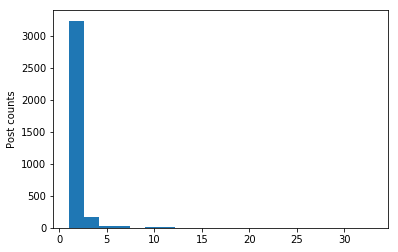

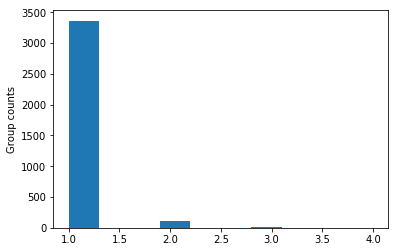

122 users in more than 1 group


In [855]:
# let's display the distribution of post frequency for all users
combined_NE_user_counts = combined_NE_user_data.groupby('status_author_id').apply(lambda x: x.loc[:, 'status_id'].nunique())
plt.hist(combined_NE_user_counts, bins=20)
plt.ylabel('Post counts')
plt.show()
# same thing but with groups (how many unique groups did user A post to)
combined_NE_user_group_counts = combined_NE_user_data.groupby('status_author_id').apply(lambda x: x.loc[:, 'group_id'].nunique())
plt.hist(combined_NE_user_group_counts)
plt.ylabel('Group counts')
plt.show()
print('%d users in more than 1 group'%(combined_NE_user_group_counts[combined_NE_user_group_counts > 1].shape[0]))

Not a big sample size, but we should still investigate.

In [857]:
consistent_users = list(combined_NE_user_group_counts[combined_NE_user_group_counts > 1].index)
combined_NE_user_data_consistent_users = combined_NE_user_data[combined_NE_user_data.loc[:, 'status_author_id'].isin(consistent_users)]
print('%d consistent-user NE-mentions'%(combined_NE_user_data_consistent_users.shape[0]))

535 consistent-user NE-mentions


Wow. This is not helpful. We should still test the proportions to see if the prior finding holds.

We can do a macro-average and an average over proportions. 

In [884]:
def descriptor_prob_test(data, k=5, bootstrap=False):
    data_in_group = data[data.loc[:, 'dist_%d'%(k)]==1]
    data_not_in_group = data[data.loc[:, 'dist_%d'%(k)]==0]
    N_in_group = data_in_group.shape[0]
    N_not_in_group = data_not_in_group.shape[0]
    # macro-average
    N = data.shape[0]
    p_in_group = data_in_group.loc[:, 'has_descriptor_subtree'].sum() / N
    p_not_in_group = data_not_in_group.loc[:, 'has_descriptor_subtree'].sum() / N
    test_stat, p_val = binomial_test(p_in_group, p_not_in_group, N_in_group, N_not_in_group)
    print('$P(d | l in g)=%.3E$ (N=%d), P(d | l not in g)=%.3E (N=%d)'%(p_in_group, N_in_group, p_not_in_group, N_not_in_group))
    print('difference is significant with test_stat=%.3E (p=%.3E)'%(test_stat, p_val))
    # if bootstrap then compute error bounds!! yikes
    if(bootstrap):
        N_bootstrap = 1000
        pass
    return p_in_group, p_not_in_group, N_in_group, N_not_in_group
    # compare these probabilities against baseline data
#     if(full_data is not None):
#         full_data_in_group = full_data[full_data.loc[:, 'dist_%d'%(k)]==1]
#         full_data_not_in_group = full_data[full_data.loc[:, 'dist_%d'%(k)]==1]
        
#         full_data_without_consistent = data[data.loc[:, '']]

testing full
testing k=5
$P(d | l in g)=3.368E-02$ (N=3772), P(d | l not in g)=5.132E-02 (N=2463)
difference is significant with test_stat=-3.449E+00 (p=2.818E-04)
testing k=10
$P(d | l in g)=3.865E-02$ (N=4218), P(d | l not in g)=4.635E-02 (N=2017)
difference is significant with test_stat=-1.432E+00 (p=7.611E-02)
testing k=20
$P(d | l in g)=4.523E-02$ (N=4717), P(d | l not in g)=3.978E-02 (N=1518)
difference is significant with test_stat=9.020E-01 (p=8.165E-01)
testing k=50
$P(d | l in g)=6.047E-02$ (N=5398), P(d | l not in g)=2.454E-02 (N=837)
difference is significant with test_stat=4.219E+00 (p=1.000E+00)
testing consistent
testing k=5
$P(d | l in g)=2.991E-02$ (N=320), P(d | l not in g)=5.234E-02 (N=215)
difference is significant with test_stat=-1.315E+00 (p=9.423E-02)
testing k=10
$P(d | l in g)=3.738E-02$ (N=367), P(d | l not in g)=4.486E-02 (N=168)
difference is significant with test_stat=-4.109E-01 (p=3.406E-01)
testing k=20
$P(d | l in g)=3.925E-02$ (N=416), P(d | l not in g)

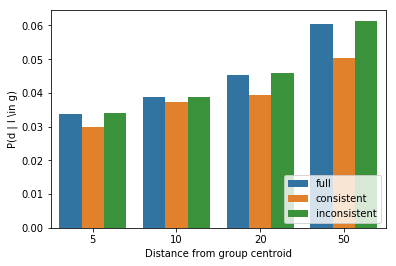

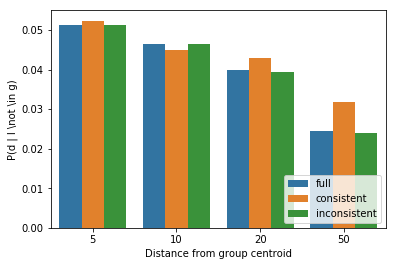

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


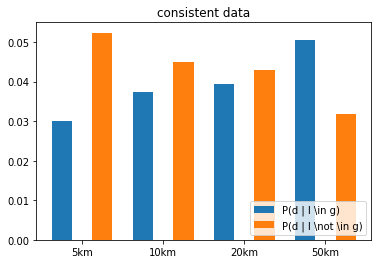

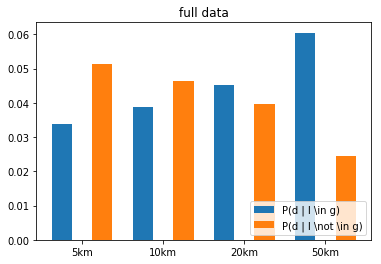

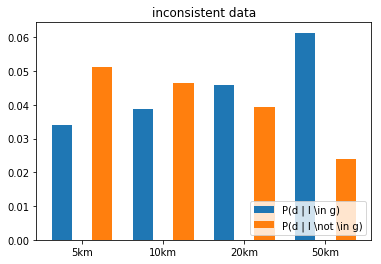

In [905]:
import seaborn as sns
k_vals = [5, 10, 20, 50]
combined_NE_user_data_inconsistent_users = combined_NE_user_data[~combined_NE_user_data.loc[:, 'status_author_id'].isin(consistent_users)]
data_list = [combined_NE_user_data, combined_NE_user_data_consistent_users, combined_NE_user_data_inconsistent_users]
data_name_list = ['full', 'consistent', 'inconsistent']
prob_data = []
for data, data_name in zip(data_list, data_name_list):
    print('testing %s'%(data_name))
    for k_val in k_vals:
        print('testing k=%d'%(k_val))
        p_in_group, p_not_in_group, N_in_group, N_not_in_group = descriptor_prob_test(data, k=k_val)
        prob_data.append([p_in_group, p_not_in_group, N_in_group, N_not_in_group])
prob_data = pd.DataFrame(prob_data, columns=['p_in_group', 'p_not_in_group', 'N_in_group', 'N_not_in_group'])
prob_data.loc[:, 'k'] = np.repeat(np.array(k_vals).reshape(1, len(k_vals)), axis=0, repeats=len(data_list)).flatten()
prob_data.loc[:, 'data_type'] = np.repeat(np.array(data_name_list), len(k_vals))
# barplot
# across-group
print(prob_data)
prob_names = ['p_in_group', 'p_not_in_group']
prob_names_full = ['P(d | l \in g)', 'P(d | l \\not \in g)']
for prob_name, prob_name_full in zip(prob_names, prob_names_full):
    sns.barplot(x='k', y=prob_name, hue='data_type', data=prob_data)
    plt.xlabel('Distance from group centroid')
    plt.ylabel(prob_name_full)
    plt.legend(loc='lower right')
    plt.show()
# within-group
for data_name_i, data_i in prob_data.groupby('data_type'):
    data_i.sort_values('k', inplace=True, ascending=True)
    bar_offset = 0.5
    bar_width = 0.25
    X = np.arange(len(k_vals))
    k_val_str = ['%dkm'%(k) for k in k_vals]
    for j, (prob_name, prob_name_full) in enumerate(zip(prob_names, prob_names_full)):
        plt.bar(X + bar_offset*j - 0.25, data_i.loc[:, prob_name], width=bar_width, label=prob_name_full)
    plt.xticks(X, k_val_str)
    plt.legend(loc='lower right')
    plt.title('%s data'%(data_name_i))
    plt.show()

Interesting!

- No within-group effects for consistent users
- Inconsistent users tend to use descriptor more when location in group, as compared to consistent users => consistent users have more local awareness? unclear

### Test local vs. non-local descriptor use

What if we compare locals (people who post in one group multiple times) with non-locals (people who post in the group less) and transients (people who post only once)?

In [963]:
def assign_user_local_transient(user_data):
#     print('author %s'%(user_data.loc[:, 'status_author_id'].unique()))
    # majority of posts in one group
    group_counts = user_data.loc[:, 'group_id'].value_counts()
    group_pct = group_counts / group_counts.sum()
    group_pct.sort_values(inplace=True, ascending=False)
    # strong local
#     print(group_pct)
    if(len(group_pct) > 1 and group_pct.iloc[0] > group_pct.iloc[1]):
        strong_local_groups = [group_pct.index[0]]
    # weak local
    else:
        strong_local_groups = []
    if(len(group_pct) > 1):
        weak_local_groups = group_counts[group_counts > 1].index
    else:
        weak_local_groups = []
    user_data.loc[:, 'strong_local'] = user_data.loc[:, 'group_id'].apply(lambda x: x in strong_local_groups)
    user_data.loc[:, 'weak_local'] = user_data.loc[:, 'group_id'].apply(lambda x: x in weak_local_groups)
    # transient
    transient_groups = group_counts[group_counts==1].index
    user_data.loc[:, 'transient'] = user_data.loc[:, 'group_id'].apply(lambda x: x in transient_groups)
#     print(user_data.loc[:, ['local', 'transient']])
    return user_data
NE_local_transient_user_data = combined_NE_user_data.groupby('status_author_id').apply(lambda x: assign_user_local_transient(x))

In [965]:
print('%d/%d strong locals total'%(NE_local_transient_user_data.loc[:, 'strong_local'].sum(), NE_local_transient_user_data.shape[0]))
print('%d/%d weak locals total'%(NE_local_transient_user_data.loc[:, 'weak_local'].sum(), NE_local_transient_user_data.shape[0]))
print('%d/%d non-transient total'%(NE_local_transient_user_data.loc[:, 'transient'].apply(lambda x: 1-x).sum(), NE_local_transient_user_data.shape[0]))

213/6235 strong locals total
384/6235 weak locals total
3771/6235 non-transient total


Two hypotheses:

- H0: $P(d | l \in g, u=\text{local})$ < $P(d | l \in g, u=\text{non-local})$
- H0: $P(d | l \in g, u=\text{non-transient})$ < $P(d | l \in g, u=\text{transient})$

In [1005]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, ttest_rel
def group_prob_test(data, group_label, k=5, k_local=1, bootstrap=False):
    has_descriptor = 1
    data_k  = data[data.loc[:, 'dist_%d'%(k)]==k_local]
    data_in_group = data_k[data_k.loc[:, group_label]]
    data_not_in_group = data_k[~data_k.loc[:, group_label]]
    N_in_group = data_in_group.shape[0]
    N_not_in_group = data_not_in_group.shape[0]
    # macro-average
    N_in_group = data_in_group.shape[0]
    N_not_in_group = data_not_in_group.shape[0]
    print('N_test=%d'%(data_in_group[data_in_group.loc[:, 'has_descriptor_subtree']==has_descriptor].shape[0]))
    count_in_group = (data_in_group.loc[:, 'has_descriptor_subtree']==has_descriptor).sum()
    count_not_in_group = (data_not_in_group.loc[:, 'has_descriptor_subtree']==has_descriptor).sum()
#     test_stat, p_val = proportions_ztest([count_in_group, count_not_in_group], [N_in_group, N_not_in_group])
    p_in_group = count_in_group / N_in_group
    p_not_in_group = count_not_in_group / N_not_in_group
    test_stat, p_val = binomial_test(p_in_group, p_not_in_group, N_in_group, N_not_in_group)
    k_local_str = 'l in g' if k_local==1 else 'l not in g'
    print('$P(d | %s, group)=%.3f$ (N=%d), P(d | %s, non-group)=%.3f (N=%d)'%(k_local_str, p_in_group, N_in_group, k_local_str, p_not_in_group, N_not_in_group))
    print('difference is significant with test_stat=%.3f (p=%.3E)'%(test_stat, p_val))
    # if bootstrap then permute data, compute random probs, determine if real probs are outside CI
    if(bootstrap):
        N_B = 100
        B_size = 50
        np.random.seed(123)
        p_in_group_B = []
        p_not_in_group_B = []
#         data_B = data_k.copy()
        for i in range(N_B):
            data_B = data_k.loc[np.random.choice(data_k.index, B_size, replace=True), :]
#             data_B.loc[:, group_label] = np.random.choice(data_B.loc[:, group_label].values, data_B.shape[0], replace=False)
            data_in_group = data_B[data_B.loc[:, group_label]]
            data_not_in_group = data_B[~data_B.loc[:, group_label]]
            N_in_group = data_in_group.shape[0]
            N_not_in_group = data_not_in_group.shape[0]
            # macro-average
            N_in_group = data_in_group.shape[0]
            N_not_in_group = data_not_in_group.shape[0]
            count_in_group = (data_in_group.loc[:, 'has_descriptor_subtree']==has_descriptor).sum()
            count_not_in_group = (data_not_in_group.loc[:, 'has_descriptor_subtree']==has_descriptor).sum()
            #     test_stat, p_val = proportions_ztest([count_in_group, count_not_in_group], [N_in_group, N_not_in_group])
            p_in_group_i = count_in_group / N_in_group
            p_not_in_group_i = count_not_in_group / N_not_in_group
            p_in_group_B.append(p_in_group_i)
            p_not_in_group_B.append(p_not_in_group_i)
        # compute difference according to t-test
        test_stat, p_val = ttest_rel(p_in_group_B, p_not_in_group_B)
        print('bootstrap prob')
        print('$P(d | %s, group)=%.3f+/-%.3f$, P(d | %s, non-group)=%.3f+/-%.3f'%(k_local_str, np.mean(p_in_group_B), np.std(p_in_group_B)/(B_size**.5), k_local_str, np.mean(p_not_in_group_B), np.std(p_not_in_group_B)/(B_size**.5)))
        print('bootstrap difference is significant t=%.3f (p=%.3E)'%(test_stat, p_val))
        ## if bootstrap, return full distribution of probs
        return p_in_group_B, p_not_in_group_B, N_in_group, N_not_in_group
    else:
        return p_in_group, p_not_in_group, N_in_group, N_not_in_group

In [996]:
# across-group
group_labels = ['strong_local', 'weak_local', 'transient']
k_vals = [5, 10, 20, 50]
prob_data = []
for k_local in [1, 0]:
    print('k_local %s'%(has_descriptor))
    for group_label in group_labels:
        print('group=%s'%(group_label))
        for k in k_vals:
            print('testing k=%d'%(k))
            p_in_group, p_not_in_group, N_in_group, N_not_in_group = group_prob_test(NE_local_transient_user_data, group_label, k=k, k_local=k_local)
            prob_data.append([p_in_group, p_not_in_group, N_in_group, N_not_in_group, k, group_label, k_local])
prob_data = pd.DataFrame(prob_data, columns=['p_in_group', 'p_not_in_group', 'N_in_group', 'N_not_in_group', 'k', 'group_label', 'k_local'])
display(prob_data)

k_local 0
group=strong_local
testing k=5
N_test=10
$P(d | l in g, group)=7.353E-02$ (N=136), P(d | l in g, non-group)=5.501E-02 (N=3636)
difference is significant with test_stat=9.250E-01 (p=8.225E-01)
testing k=10
N_test=12
$P(d | l in g, group)=7.947E-02$ (N=151), P(d | l in g, non-group)=5.631E-02 (N=4067)
difference is significant with test_stat=1.204E+00 (p=8.857E-01)
testing k=20
N_test=12
$P(d | l in g, group)=7.186E-02$ (N=167), P(d | l in g, non-group)=5.934E-02 (N=4550)
difference is significant with test_stat=6.700E-01 (p=7.486E-01)
testing k=50
N_test=15
$P(d | l in g, group)=8.152E-02$ (N=184), P(d | l in g, non-group)=6.943E-02 (N=5214)
difference is significant with test_stat=6.325E-01 (p=7.365E-01)
group=weak_local
testing k=5
N_test=14
$P(d | l in g, group)=6.393E-02$ (N=219), P(d | l in g, non-group)=5.516E-02 (N=3553)
difference is significant with test_stat=5.489E-01 (p=7.085E-01)
testing k=10
N_test=17
$P(d | l in g, group)=6.538E-02$ (N=260), P(d | l in g, non-gro

,p_in_group,p_not_in_group,N_in_group,N_not_in_group,k,group_label,k_local
0,0.073529,0.055006,136,3636,5,strong_local,1
1,0.079470,0.056307,151,4067,10,strong_local,1
2,0.071856,0.059341,167,4550,20,strong_local,1
3,0.081522,0.069428,184,5214,50,strong_local,1
4,0.063927,0.055165,219,3553,5,weak_local,1
5,0.065385,0.056594,260,3958,10,weak_local,1
6,0.058020,0.059901,293,4424,20,weak_local,1
7,0.068323,0.069937,322,5076,50,weak_local,1
8,0.056869,0.054826,1565,2207,5,transient,1
9,0.059545,0.055489,1713,2505,10,transient,1


- Weak tendency for strong locals to use descriptor more...maybe because they're more committed to group and therefore more committed to accurate information dissemination.
- This tendency is less pronounced for weak locals...so maybe descriptors are used by locals 
- No difference for transient vs. non-transient, probably because group status doesn't mean too much.

This analysis was clumsy - we should test users who are locals in at least one group, because we want to see potential modulation between local/non-local use of descriptors.

In [973]:
strong_local_users = NE_local_transient_user_data[NE_local_transient_user_data.loc[:, 'strong_local']==1].loc[:, 'status_author_id'].unique()
weak_local_users = NE_local_transient_user_data[NE_local_transient_user_data.loc[:, 'weak_local']==1].loc[:, 'status_author_id'].unique()
print('%d strong local users'%(len(strong_local_users)))
print('%d weak local users'%(len(weak_local_users)))
NE_local_transient_user_data_strong_local = NE_local_transient_user_data[NE_local_transient_user_data.loc[:, 'status_author_id'].isin(strong_local_users)]
NE_local_transient_user_data_weak_local = NE_local_transient_user_data[NE_local_transient_user_data.loc[:, 'status_author_id'].isin(weak_local_users)]
print('%d strong local posts'%(NE_local_transient_user_data_strong_local.shape[0]))
print('%d weak local posts'%(NE_local_transient_user_data_weak_local.shape[0]))

57 strong local users
73 weak local users
324 strong local posts
436 weak local posts


In [1008]:
# within-group comparison
data_names = ['strong_local', 'weak_local']
data_list = [NE_local_transient_user_data_strong_local, NE_local_transient_user_data_weak_local]
k_vals = [5, 10, 20, 50]

## in/out group test
print('in/out-group test')
in_out_prob_data = []
for k_local in [1, 0]:
    print('k_local %s'%(k_local))
    for data_name_i, data_i in zip(data_names, data_list):
        print('group=%s'%(data_name_i))
        for k in k_vals:
            print('testing k=%d'%(k))
            p_in_group_B, p_not_in_group_B, N_in_group, N_not_in_group = group_prob_test(data_i, group_label, k=k, k_local=k_local, bootstrap=True)
            in_out_prob_data_i = pd.DataFrame([p_in_group_B, p_not_in_group_B], index=['p_in_group', 'p_not_in_group']).transpose()
            in_out_prob_data_i.loc[:, 'N_in_group'] = N_in_group
            in_out_prob_data_i.loc[:, 'N_not_in_group'] = N_not_in_group
            in_out_prob_data_i.loc[:, 'k_local'] = k_local
            in_out_prob_data_i.loc[:, 'data_name'] = data_name_i
            in_out_prob_data_i.loc[:, 'k'] = k
            in_out_prob_data.append(in_out_prob_data_i)
in_out_prob_data = pd.concat(in_out_prob_data, axis=0)

## location-in-group
print('location-in-group')
for data_name_i, data_i in zip(data_names, data_list):
    print('testing %s data'%(data_name_i))
    for k in k_vals:
        p_in_group, p_not_in_group, N_in_group, N_not_in_group = descriptor_prob_test(data_i, k=k)

in/out-group test
k_local 1
group=strong_local
testing k=5
N_test=1
$P(d | l in g, group)=0.029$ (N=35), P(d | l in g, non-group)=0.082 (N=170)
difference is significant with test_stat=-1.113 (p=1.329E-01)
bootstrap prob
$P(d | l in g, group)=0.043+/-0.012$, P(d | l in g, non-group)=0.082+/-0.005
bootstrap difference is significant t=-4.240 (p=5.022E-05)
testing k=10
N_test=1
$P(d | l in g, group)=0.026$ (N=38), P(d | l in g, non-group)=0.083 (N=193)
difference is significant with test_stat=-1.221 (p=1.110E-01)
bootstrap prob
$P(d | l in g, group)=0.028+/-0.009$, P(d | l in g, non-group)=0.087+/-0.006
bootstrap difference is significant t=-7.456 (p=3.442E-11)
testing k=20
N_test=1
$P(d | l in g, group)=0.024$ (N=42), P(d | l in g, non-group)=0.075 (N=213)
difference is significant with test_stat=-1.218 (p=1.116E-01)
bootstrap prob
$P(d | l in g, group)=0.021+/-0.007$, P(d | l in g, non-group)=0.070+/-0.005
bootstrap difference is significant t=-7.026 (p=2.734E-10)
testing k=50
N_test=2

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


bootstrap prob
$P(d | l in g, group)=nan+/-nan$, P(d | l in g, non-group)=0.057+/-0.005
bootstrap difference is significant t=nan (p=NAN)
testing k=50
N_test=2
$P(d | l in g, group)=0.043$ (N=46), P(d | l in g, non-group)=0.068 (N=322)
difference is significant with test_stat=-0.638 (p=2.616E-01)
bootstrap prob
$P(d | l in g, group)=0.039+/-0.012$, P(d | l in g, non-group)=0.065+/-0.005
bootstrap difference is significant t=-3.156 (p=2.122E-03)
k_local 0
group=strong_local
testing k=5
N_test=2
$P(d | l not in g, group)=0.118$ (N=17), P(d | l not in g, non-group)=0.098 (N=102)
difference is significant with test_stat=0.249 (p=5.982E-01)
bootstrap prob
$P(d | l not in g, group)=0.133+/-0.016$, P(d | l not in g, non-group)=0.102+/-0.007
bootstrap difference is significant t=2.447 (p=1.617E-02)
testing k=10
N_test=2
$P(d | l not in g, group)=0.143$ (N=14), P(d | l not in g, non-group)=0.101 (N=79)
difference is significant with test_stat=0.463 (p=6.783E-01)
bootstrap prob
$P(d | l not in g

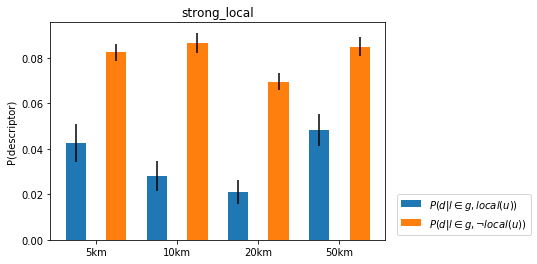

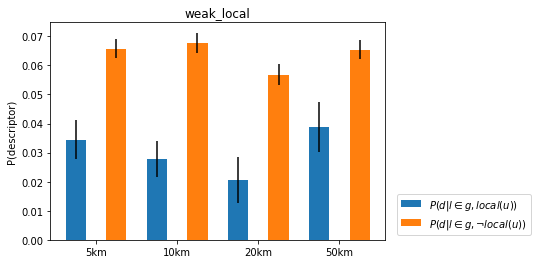

In [1034]:
## make bar plot
k_local = 1
# data_name = 'strong_local'
X = np.arange(len(k_vals))
k_vals_str = ['%dkm'%(k) for k in k_vals]
bar_offset = 0.5
bar_width = 0.25
for i, data_name in enumerate(data_names):
    in_out_prob_data_i = in_out_prob_data[(in_out_prob_data.loc[:, 'data_name']==data_name) & (in_out_prob_data.loc[:, 'k_local']==k_local)]
    p_in_group_mean = in_out_prob_data_i.groupby('k').apply(lambda x: x.loc[:, 'p_in_group'].mean())
    p_not_in_group_mean = in_out_prob_data_i.groupby('k').apply(lambda x: x.loc[:, 'p_not_in_group'].mean())
    p_in_group_err = in_out_prob_data_i.groupby('k').apply(lambda x: x.loc[:, 'p_in_group'].std()/(x.shape[0]**.5))
    p_not_in_group_err = in_out_prob_data_i.groupby('k').apply(lambda x: x.loc[:, 'p_not_in_group'].std()/(x.shape[0]**.5))
    # means
    plt.bar(X - 0.25, p_in_group_mean, width=bar_width, label='$P(d | l \in g, local(u))$',)
    plt.bar(X + 0.25, p_not_in_group_mean, width=bar_width, label='$P(d | l \in g, \\neg local(u))$')
    # errors
    plt.errorbar(X - 0.25, p_in_group_mean, yerr=p_in_group_err, ls='', color='k')
    plt.errorbar(X + 0.25, p_not_in_group_mean, yerr=p_not_in_group_err, ls='', color='k')
    plt.legend(loc='lower right', bbox_to_anchor=[1.45, 0.])
    plt.xticks(X, k_vals_str)
    plt.ylabel('P(descriptor)')
    plt.title(data_name)
    plt.show()

- Weak tendency for less descriptor use when user is posting in local group versus non-local => success!
- Weak tendency for more descriptor use among locals when location is in group versus not in group => not success!
    - Again, there could be multiple layers to descriptor use: elaboration, address information, etc.

What about within-group?